### Final Project Submission

Please fill out:
* Student name: Jeff Spagnola
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


<img src="fb_logo_rect.jpg">

## Introduction

In this notebook, we will be examining data from house sales in King County, Washington in order to determine what a potential seller may be able to do in order to increase the final sale price of their home.  While there are many factors at play when it comes to home value, we will attempt to figure out key features that drive sale price using data scrubbing and linear regression models.  

In this notebook, we will attempt to answer three important questions:
  - What are the three most important features to consider in regards to sale price?
  - How much does each feature affect the overall sale price? 
  - A third question I haven't thought of yet.  

### Importing Packages

In [1]:
# !pip install missingno
# !pip install mlxtend

In [2]:
# Importing necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as ms

#for feature engineering
from sklearn.preprocessing import StandardScaler

# for modeling
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

### Functions

In [3]:
def df_info(df):
    # gets shape, describe and info for datasets
    return df.shape, df.describe(), df.info()

def scatter_plot_exploration(col):
    ax = plt.figure(figsize = (8,6))
    ax = sns.scatterplot(x = df[col], y = df['price'])
    ax.set_title('{} vs. Price'.format(col), fontsize = 20)
    ax.set_xlabel('{}'.format(col), fontsize = 16)
    ax.set_ylabel('Sale Price', fontsize = 16);

def plot_col(df, col, target = 'price'):
    g = sns.jointplot(data = df, x = col, y = target, kind = 'reg')
    plt.suptitle(f"{col} vs. {target}");
    return g

def outliers_range_iqr(df, column, distance = 1.5):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    lower_threshold = df[column].quantile(0.25) - (iqr * distance)
    upper_threshold = df[column].quantile(0.75) + (iqr * distance)
    return lower_threshold, upper_threshold

def find_outliers_iqr(df, column):
    lower_threshold, upper_threshold = outliers_range_iqr(df, column)
    outliers = []
    for i in df[column]:
        if i > upper_threshold:
            outliers.append(i)
        elif i < lower_threshold:
            outliers.append(i)
        else: 
            pass
    return outliers

def remove_outliers_iqr(df, column):
    outliers = find_outliers_iqr(df, column)
    outliers = pd.Series(outliers)
    df_new = df[~df[column].isin(outliers)]
    return df_new

def check_normality(x, y):
    fix, axes = plt.subplots(cols = 2, figsize = (10, 6))
    sns.distplot(x, ax = axes[0], kde = False, bins = 'auto')
    axes[0].set(label = 'X')
    sns.distplot(y, ax = axes[1], kde = False, bins = 'auto')
    axes[1].set(label = 'Y')
    x_normal = stats.normaltest(x)
    print(x_normal)
    y_normal = stats.normaltest(y)
    print(y_normal)
    
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

def heatmap(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (16,12))
    sns.set(style = 'white')
    sns.heatmap(corr, mask = mask, cmap="Blues", annot = True);
    
def diagnostic_plots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    df[column].hist(bins = 30)
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist = 'norm', plot = plt)
    plt.title('{}'.format(column))
    plt.show()
    
def scatter_box_plots (df, column):
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.regplot(data = df, x = column, y = 'price', fit_reg = True)
    plt.title('{}'.format(column))
    plt.subplot(1,2,2)
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

## Obtain


### Import Data

In [4]:
# Loading and previewing the dataset

df = pd.read_csv('kc_house_data.csv')
pd.set_option('display.max_columns', 0)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


### Exploratory Visualizations - MOVE TO EXPLORE SECTION

#### Scatter Plots

In [5]:
# for col in df.columns:
#     scatter_plot_exploration(col)

#### Reg Plots

In [6]:
# for col in df.columns:
#     plot_col(df, col)

## Scrub

##### Column Descriptions
>Below are the column descriptions that were given along with the dataset.  

- id - A notation for a house
- date - Date house was sold
- price - Price is prediction target
- bedrooms Number of Bedrooms/House
- bathrooms - Number of bathrooms/bedrooms
- sqft_living - Square footage of the home
- sqft_lot - Square footage of the lot
- floors - Total floors (levels) in house
- waterfront - House which has a view to a waterfront
- view - Has been viewed
- condition - How good the condition is ( Overall )
- grade - Overall grade given to the housing unit, based on King County grading system
- sqft_above - square footage of house apart from basement
- sqft_basement - square footage of the basement
- yr_built - Built Year
- yr_renovated - Year when house was renovated
- zipcode - Zipcode
- lat - Latitude coordinate
- long - Longitude coordinate
- sqft_living15 - Living room area in 2015 (implies-- some renovations) This might or might not have affected the lotsize area
- sqft_lot15 - Lot size area in 2015 (implies-- some renovations)

In [7]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.0,1955,0.000,98178,47.511,-122.257,1340,5650
1,6414100192,12/9/2014,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.0,1951,1991.000,98125,47.721,-122.319,1690,7639
2,5631500400,2/25/2015,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.0,1933,nan,98028,47.738,-122.233,2720,8062
3,2487200875,12/9/2014,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.0,1965,0.000,98136,47.521,-122.393,1360,5000
4,1954400510,2/18/2015,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.0,1987,0.000,98074,47.617,-122.045,1800,7503


In [8]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

((21597, 21),
                   id       price  bedrooms  ...      long  sqft_living15  sqft_lot15
 count      21597.000   21597.000 21597.000  ... 21597.000      21597.000   21597.000
 mean  4580474287.771  540296.574     3.373  ...  -122.214       1986.620   12758.284
 std   2876735715.748  367368.140     0.926  ...     0.141        685.230   27274.442
 min      1000102.000   78000.000     1.000  ...  -122.519        399.000     651.000
 25%   2123049175.000  322000.000     3.000  ...  -122.328       1490.000    5100.000
 50%   3904930410.000  450000.000     3.000  ...  -122.231       1840.000    7620.000
 75%   7308900490.000  645000.000     4.000  ...  -122.125       2360.000   10083.000
 max   9900000190.000 7700000.000    33.000  ...  -121.315       6210.000  871200.000
 
 [8 rows x 19 columns],
 None)

>Seems to be some weirdness in here with the datatypes.  We can explore this further later on.  For now, we can drop the id column as it's just meant to be an identifier. 

In [9]:
# Dropping the id column 

df.drop(['id'], axis = 1, inplace = True)

### Dealing with sqft_basement column

In [10]:
# Checking the value counts of sqft_basement.

df['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1913.0        1
2180.0        1
3500.0        1
1852.0        1
3000.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [11]:
# Replacing the ? with nan's and changing the dtype from string to float. 

df['sqft_basement'].replace('?', np.nan, inplace = True) 
df['sqft_basement'] = df['sqft_basement'].astype('float') 

### Dealing with the Date & Year Columns

#### Date Column to Datetime

In [12]:
df['date'] = pd.to_datetime(df['date']) # convert date column from string to datetime

In [13]:
df['sales_year'] = df['date'].dt.year


In [14]:
df['sales_month'] = df['date'].dt.month # create a column show month of sale

In [15]:
df['sales_day'] = df['date'].dt.dayofweek # create a column to show day of sale

In [16]:
df.drop(['date'], axis = 1, inplace = True) # dropping date column

In [17]:
 # checking to see how the values relate to the days.  According to docstring - 0 = Monday, 1 = Tuesday, etc.

df['sales_day'].unique()

array([0, 1, 2, 4, 3, 5, 6])

#### Year Column Transformation 
>Year columns are yr_built & yr_renovated

In [18]:
type(df['sales_year'][1])

numpy.int64

In [19]:
# Create a house age column 

df['house_age'] = df['sales_year'] - df['yr_built']

In [20]:
df.drop(['sales_year', 'yr_built'], axis = 1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.000,0.000,98178,47.511,-122.257,1340,5650,10,0,59
1,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.000,1991.000,98125,47.721,-122.319,1690,7639,12,1,63
2,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.000,nan,98028,47.738,-122.233,2720,8062,2,2,82
3,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.000,0.000,98136,47.521,-122.393,1360,5000,12,1,49
4,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.000,0.000,98074,47.617,-122.045,1800,7503,2,2,28


In [21]:
# deal with null values in yr_renovated & change from float to int

df['yr_renovated'].mode() # mode = 0.0
df['yr_renovated'].fillna(0.0, axis = 0, inplace = True)
df['yr_renovated'] = df['yr_renovated'].astype('int') 
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.000,0,98178,47.511,-122.257,1340,5650,10,0,59
1,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.000,1991,98125,47.721,-122.319,1690,7639,12,1,63
2,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.000,0,98028,47.738,-122.233,2720,8062,2,2,82
3,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.000,0,98136,47.521,-122.393,1360,5000,12,1,49
4,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.000,0,98074,47.617,-122.045,1800,7503,2,2,28


In [22]:
df['yr_renovated'].value_counts()

0       20853
2014       73
2003       31
2013       31
2007       30
        ...  
1976        1
1953        1
1951        1
1946        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

>Since there's so many 0 values in here, it would make sense to transform this column into a 'was_renovated' (1,0)

In [23]:
# Change the column to a boolean

for i in df['yr_renovated']:
    if i > 0:
        df['yr_renovated'].replace(i, 1, inplace = True)

# Change column name
df['was_renovated'] = df['yr_renovated']
df.drop(['yr_renovated'], axis = 1, inplace = True)

print(df['was_renovated'].value_counts())
df.head()

0    20853
1      744
Name: was_renovated, dtype: int64


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.000,98178,47.511,-122.257,1340,5650,10,0,59,0
1,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.000,98125,47.721,-122.319,1690,7639,12,1,63,1
2,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.000,98028,47.738,-122.233,2720,8062,2,2,82,0
3,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.000,98136,47.521,-122.393,1360,5000,12,1,49,0
4,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.000,98074,47.617,-122.045,1800,7503,2,2,28,0


### Dealing with Remaining Null Values

In [24]:
# Let's preview the mildly edited dataframe again

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.000,3,1.000,1180,5650,1.000,nan,0.000,3,7,1180,0.000,98178,47.511,-122.257,1340,5650,10,0,59,0
1,538000.000,3,2.250,2570,7242,2.000,0.000,0.000,3,7,2170,400.000,98125,47.721,-122.319,1690,7639,12,1,63,1
2,180000.000,2,1.000,770,10000,1.000,0.000,0.000,3,6,770,0.000,98028,47.738,-122.233,2720,8062,2,2,82,0
3,604000.000,4,3.000,1960,5000,1.000,0.000,0.000,5,7,1050,910.000,98136,47.521,-122.393,1360,5000,12,1,49,0
4,510000.000,3,2.000,1680,8080,1.000,0.000,0.000,3,8,1680,0.000,98074,47.617,-122.045,1800,7503,2,2,28,0


In [25]:
print(df.shape)  # shape for reference
df.isna().sum()  # checking for null values

(21597, 21)


price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     454
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
sales_month         0
sales_day           0
house_age           0
was_renovated       0
dtype: int64

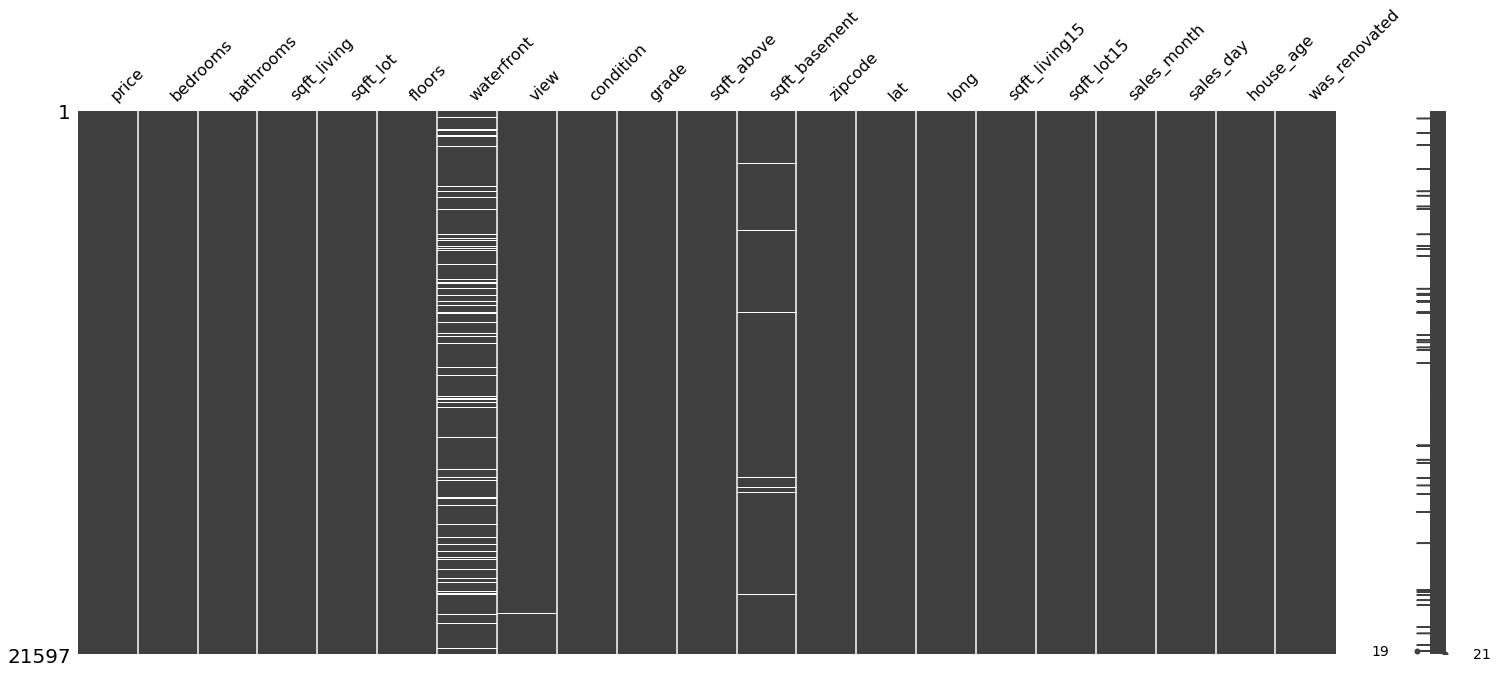

In [26]:

ms.matrix(df);

In [27]:
# Replace nan's in watefront with the mode & change type to integer.

df['waterfront'].mode() # mode = 0.0
df['waterfront'].fillna(0.0, axis = 0, inplace = True)
df['waterfront'] = df['waterfront'].astype(int)

In [28]:
# Replace nan's in view with the mode & change type to integer.

df['view'].mode() # mode = 0.0
df['view'].fillna(0.0, axis = 0, inplace = True)
df['view'] = df['view'].astype(int)

In [29]:
# Replace nan's in sqft_basement.  Both median and mode are the same so for fun, let's do the median.

df['sqft_basement'].median()  # median = 0.0
df['sqft_basement'].fillna(0.0, axis = 0, inplace = True)

In [30]:
# Let's make sure the null values are all taken care of.

df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
sales_month      0
sales_day        0
house_age        0
was_renovated    0
dtype: int64

#### Model 1 = Remove Before Final
>Just to see where we're at thus far, we'll run a baseline linear regression model with Statsmodels OLS.  

In [31]:
# run a statsmodels ols linear regression model 

features = '+'.join(df.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     2528.
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:28:20   Log-Likelihood:            -2.9436e+05
No. Observations:               21597   AIC:                         5.888e+05
Df Residuals:                   21576   BIC:                         5.889e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.487e+06   2.88e+06      0.516      0.606   -4.16e+06    7.13e+06
bedrooms      -3.606e+04   1898.374    -18.993      0.000   -3.98e+04   -3.23e+04
bathrooms      4.172e+04   3258.690     12.804      0.000    3.53e+04    4.81e+04
sqft_living     102.4171     18.054      5.673      0.000      67.031     137.804
sqft_lot          0.1254      0.048      2.621      0.009       0.032       0.219
floors         7505.9908   3596.657      2.087      0.037     456.276    1.46e+04
waterfront     6.193e+05   1.81e+04     34.188      0.000    5.84e+05    6.55e+05
view           5.306e+04   2119.655     25.033      0.000    4.89e+04    5.72e+04
condition      2.721e+04   2343.511     11.612      0.000    2.26e+04    3.18e+04
grade          9.699e+04   2157.940     44.944      0.000    9.28e+04    1.01e+05
sqft_above       78.6412     18.045      4.358      0.000      43.272     114.010
sqft_basement    48.3589     17.884      2.704      0.007      13.304      83.414
zipcode        -586.5578     32.952    -17.801      0.000    -651.145    -521.970
lat            6.015e+05   1.07e+04     56.077      0.000     5.8e+05    6.22e+05
long           -2.18e+05   1.31e+04    -16.591      0.000   -2.44e+05   -1.92e+05
sqft_living15    21.3689      3.446      6.201      0.000      14.614      28.124
sqft_lot15       -0.3834      0.073     -5.234      0.000      -0.527      -0.240
sales_month   -2778.3394    440.079     -6.313      0.000   -3640.927   -1915.752
sales_day      -180.4799    937.878     -0.192      0.847   -2018.790    1657.830
house_age      2648.0808     71.830     36.866      0.000    2507.288    2788.874
was_renovated  4.684e+04   7927.620      5.908      0.000    3.13e+04    6.24e+04
==============================================================================
Omnibus:                    18374.162   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1854524.032
Skew:                           3.570   Prob(JB):                         0.00
Kurtosis:                      47.832   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 864x432 with 0 Axes>

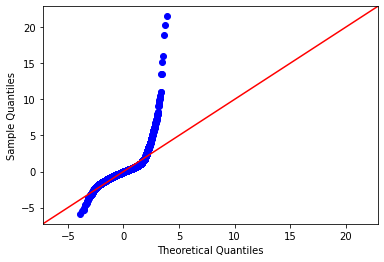

In [32]:
fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

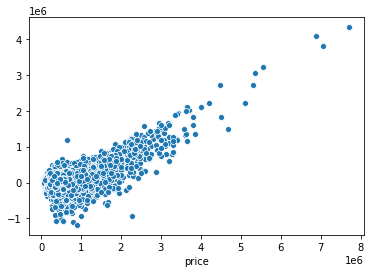

In [33]:
sns.scatterplot(df['price'], model.resid);

## Explore

### Initial Exploration
>Now that we have at least a "clean" dataframe, let's see what additional scrubbing info we can pull out of it.  

In [34]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,was_renovated
0,221900.000,3,1.000,1180,5650,1.000,0,0,3,7,1180,0.000,98178,47.511,-122.257,1340,5650,10,0,59,0
1,538000.000,3,2.250,2570,7242,2.000,0,0,3,7,2170,400.000,98125,47.721,-122.319,1690,7639,12,1,63,1
2,180000.000,2,1.000,770,10000,1.000,0,0,3,6,770,0.000,98028,47.738,-122.233,2720,8062,2,2,82,0
3,604000.000,4,3.000,1960,5000,1.000,0,0,5,7,1050,910.000,98136,47.521,-122.393,1360,5000,12,1,49,0
4,510000.000,3,2.000,1680,8080,1.000,0,0,3,8,1680,0.000,98074,47.617,-122.045,1800,7503,2,2,28,0


In [35]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  float64
 12  zipcode        21597 non-null  int64  
 13  lat            21597 non-null  float64
 14  long           21597 non-null  float64
 15  sqft_living15  21597 non-null  int64  
 16  sqft_lot15     21597 non-null  int64  
 17  sales_month    21597 non-null  int64  
 18  sales_

((21597, 21),
             price  bedrooms  bathrooms  ...  sales_day  house_age  was_renovated
 count   21597.000 21597.000  21597.000  ...  21597.000  21597.000      21597.000
 mean   540296.574     3.373      2.116  ...      2.011     43.323          0.034
 std    367368.140     0.926      0.769  ...      1.461     29.377          0.182
 min     78000.000     1.000      0.500  ...      0.000     -1.000          0.000
 25%    322000.000     3.000      1.750  ...      1.000     18.000          0.000
 50%    450000.000     3.000      2.250  ...      2.000     40.000          0.000
 75%    645000.000     4.000      2.500  ...      3.000     63.000          0.000
 max   7700000.000    33.000      8.000  ...      6.000    115.000          1.000
 
 [8 rows x 21 columns],
 None)

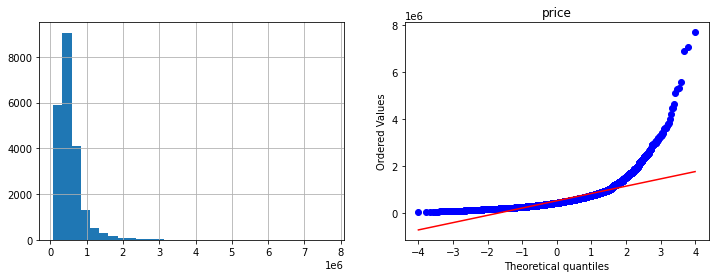

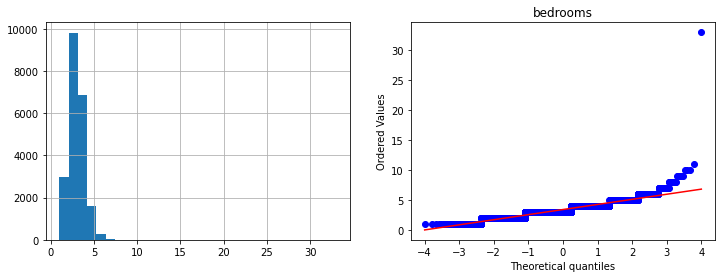

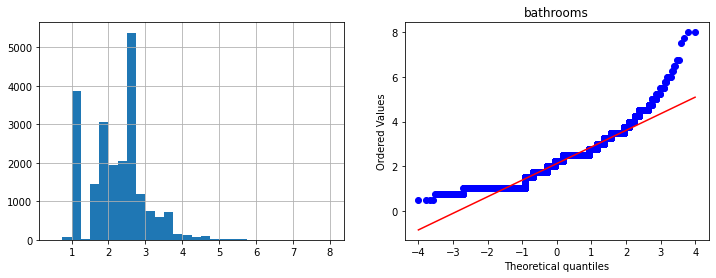

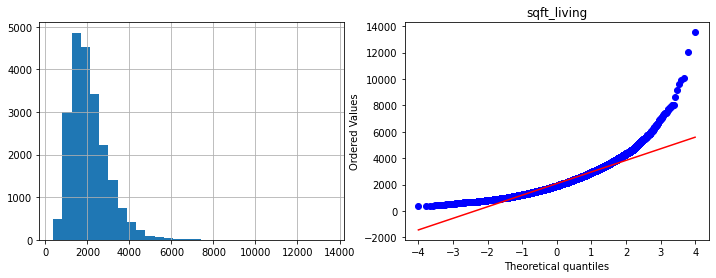

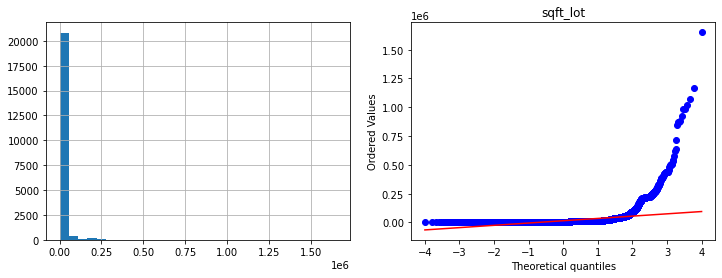

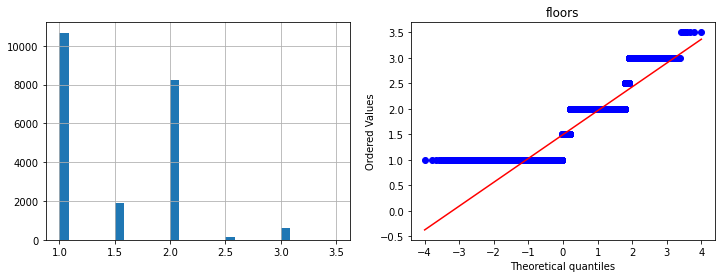

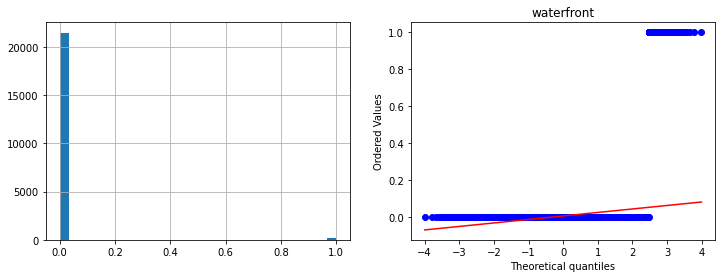

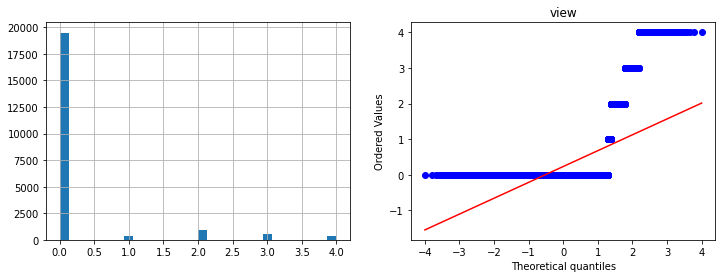

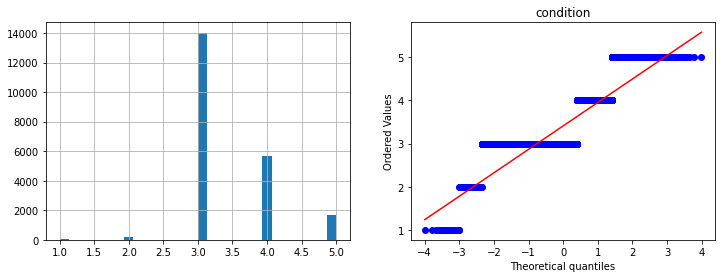

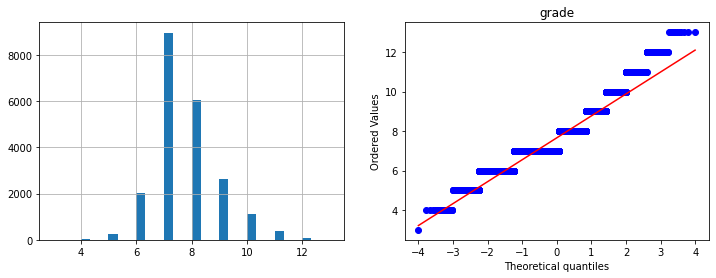

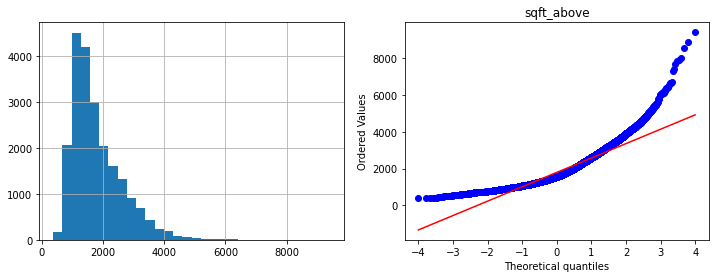

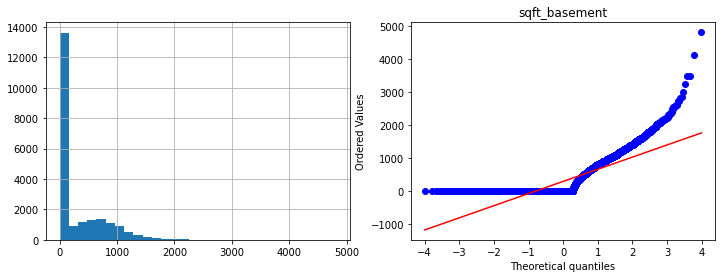

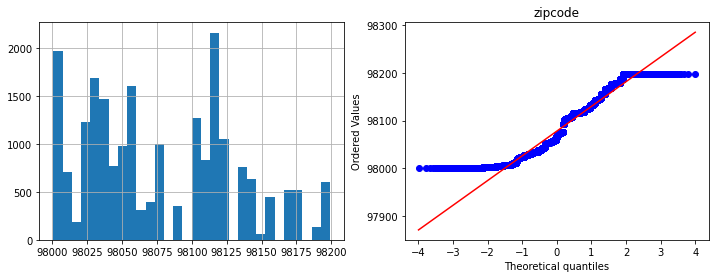

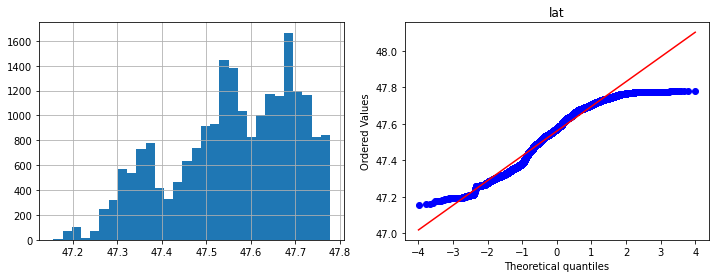

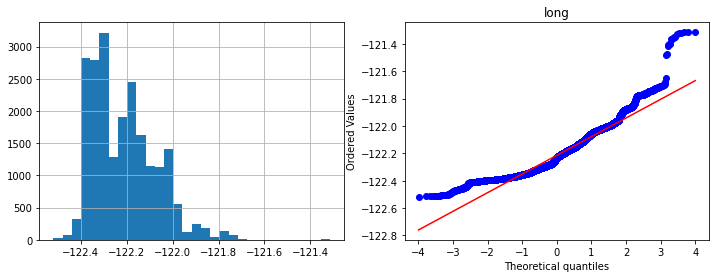

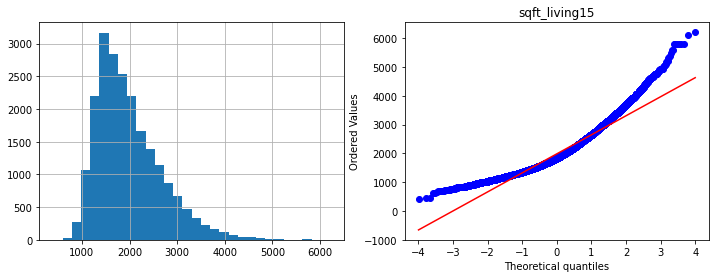

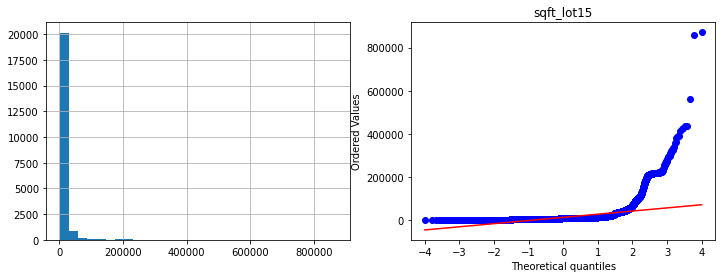

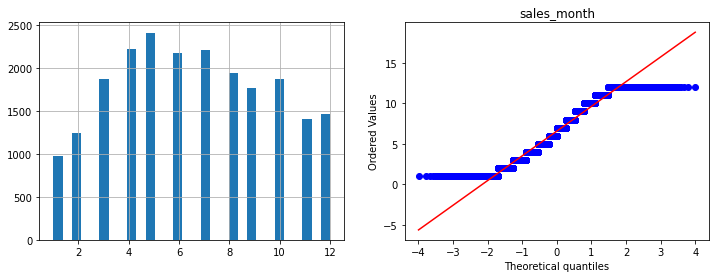

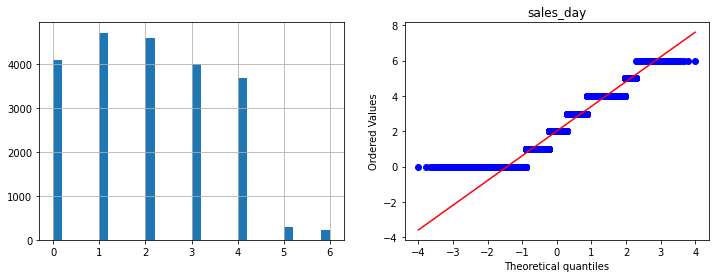

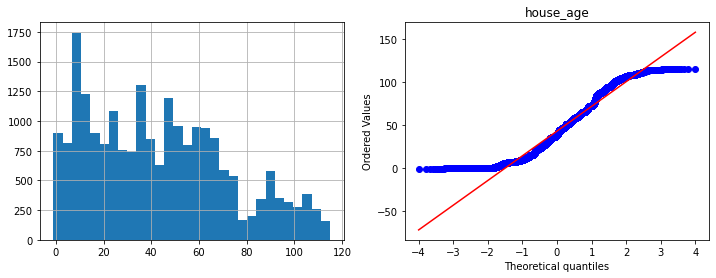

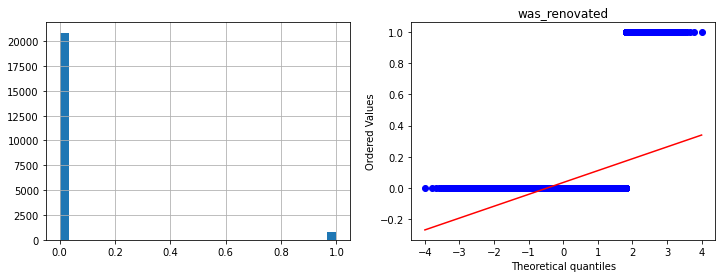

In [36]:
# Let's see what these columns look like 

for column in df.columns:
    diagnostic_plots(df, column)

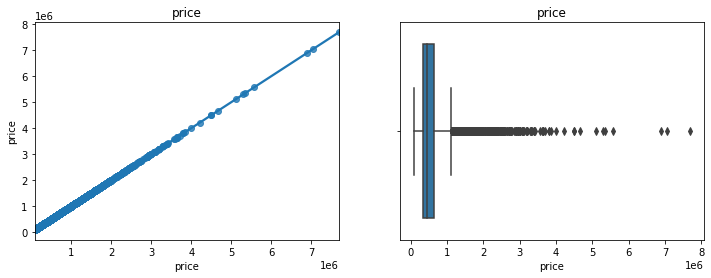

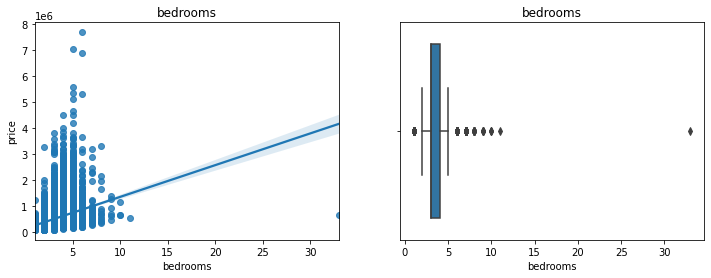

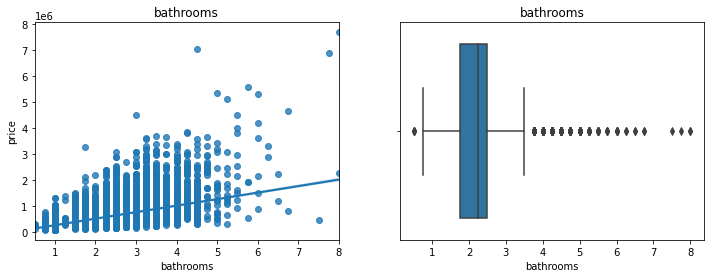

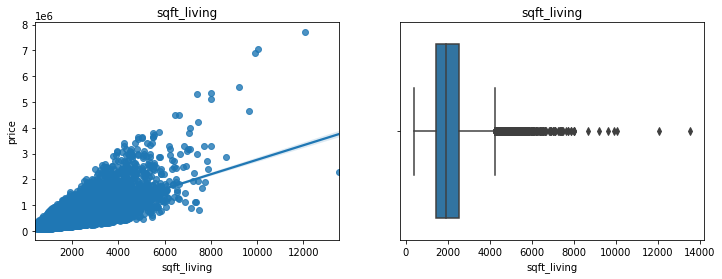

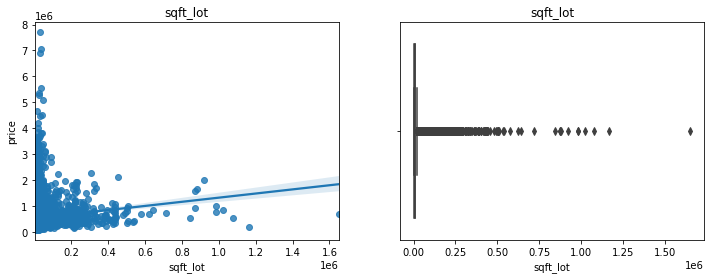

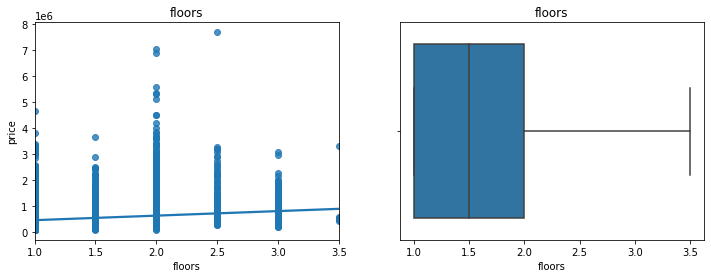

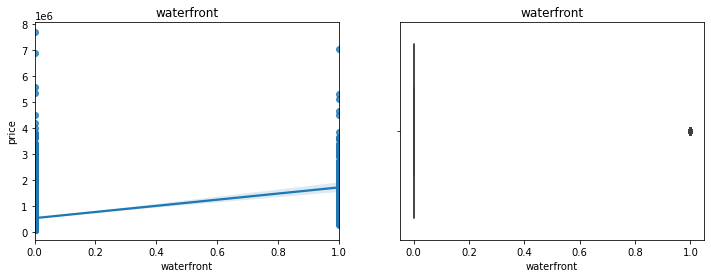

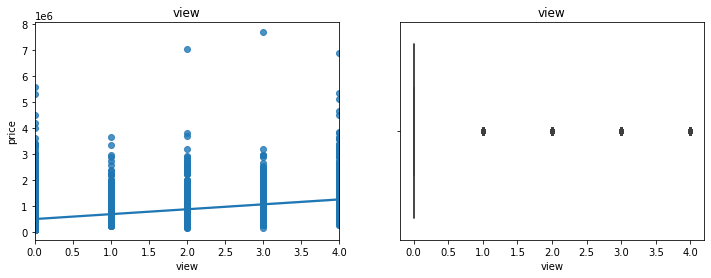

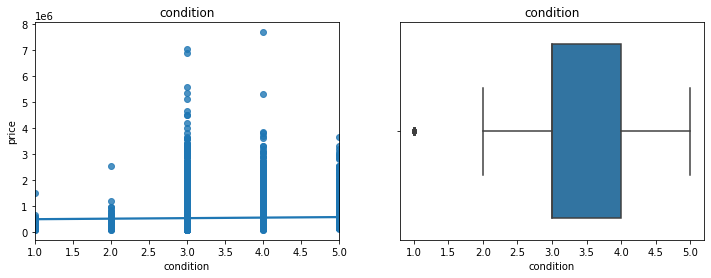

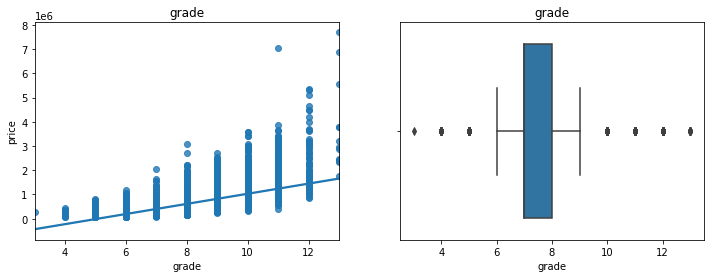

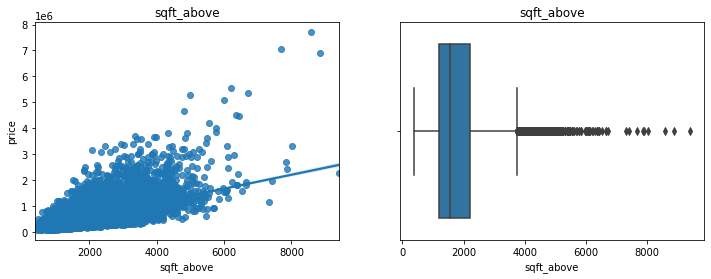

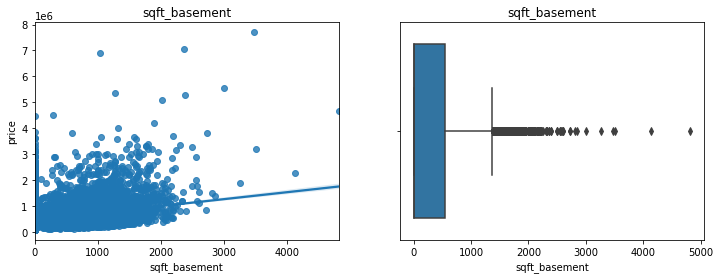

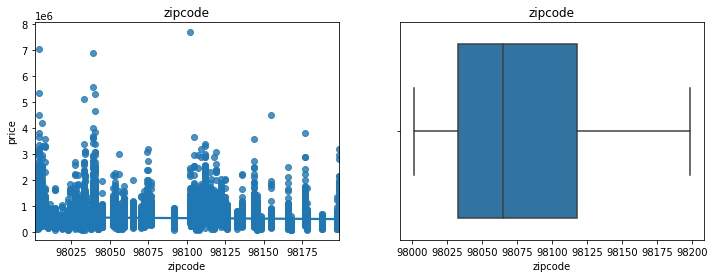

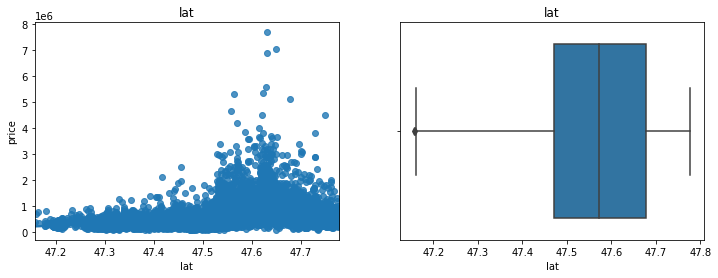

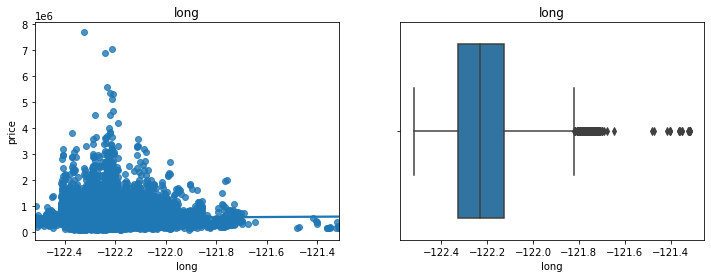

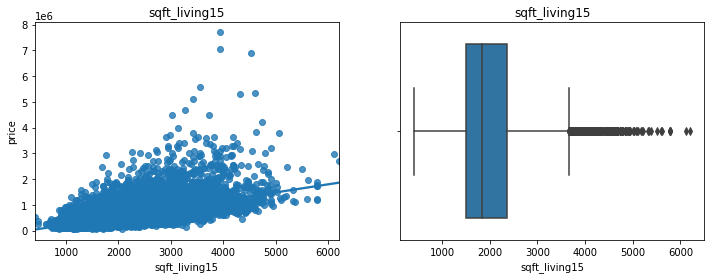

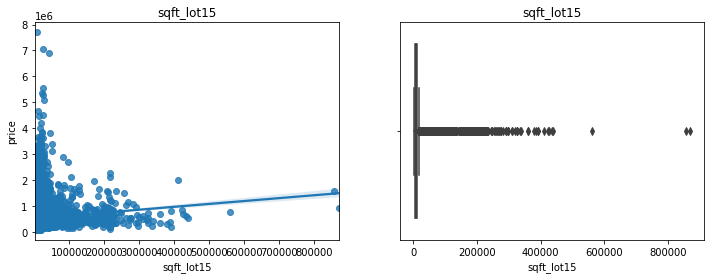

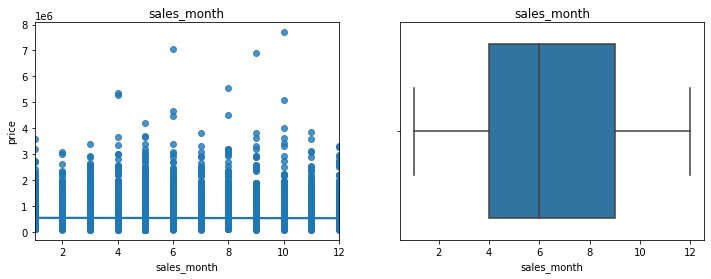

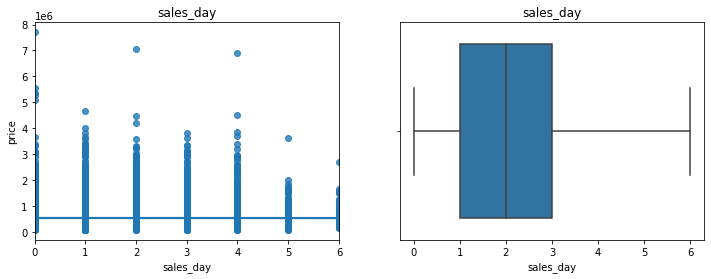

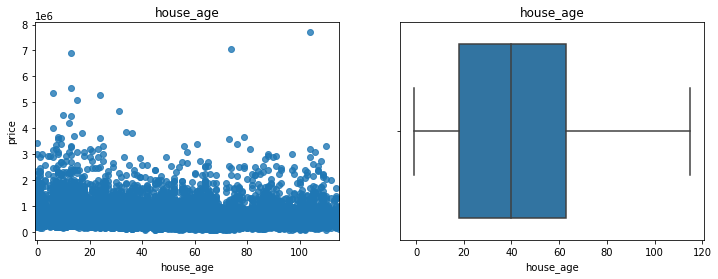

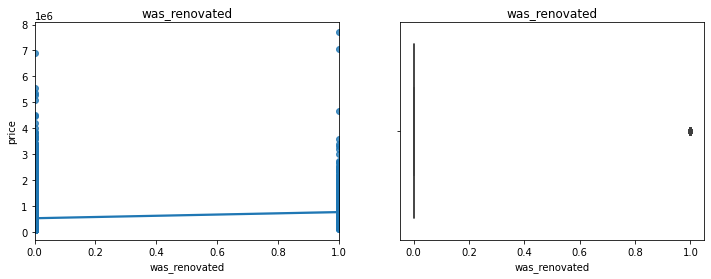

In [37]:
# Let's see scatter and box plots for all columns 

for column in df.columns:
    scatter_box_plots(df, column)

In [38]:
# Checking the value counts on the weird looking box plots

check_unique_cols = ['sqft_lot','waterfront','view', 'was_renovated', 'sqft_lot15']
for col in check_unique_cols:
    print('Column: {}'.format(df[col].value_counts()))

Column: 5000      358
6000      290
4000      251
7200      220
7500      119
         ... 
1448        1
38884       1
17313       1
35752       1
315374      1
Name: sqft_lot, Length: 9776, dtype: int64
Column: 0    21451
1      146
Name: waterfront, dtype: int64
Column: 0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64
Column: 0    20853
1      744
Name: was_renovated, dtype: int64
Column: 5000      427
4000      356
6000      288
7200      210
4800      145
         ... 
11036       1
8989        1
871200      1
809         1
6147        1
Name: sqft_lot15, Length: 8682, dtype: int64


>Lots of outlier issues here and these can be addressed on a case to case basis. Before that, we're seeing that waterfront, view & was_renovated don't offer much relevent info and can probably be dropped.

In [39]:
# dropping the irrelevant columns

df.drop(['waterfront', 'view', 'was_renovated'], axis = 1, inplace = True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age
0,221900.000,3,1.000,1180,5650,1.000,3,7,1180,0.000,98178,47.511,-122.257,1340,5650,10,0,59
1,538000.000,3,2.250,2570,7242,2.000,3,7,2170,400.000,98125,47.721,-122.319,1690,7639,12,1,63
2,180000.000,2,1.000,770,10000,1.000,3,6,770,0.000,98028,47.738,-122.233,2720,8062,2,2,82
3,604000.000,4,3.000,1960,5000,1.000,5,7,1050,910.000,98136,47.521,-122.393,1360,5000,12,1,49
4,510000.000,3,2.000,1680,8080,1.000,3,8,1680,0.000,98074,47.617,-122.045,1800,7503,2,2,28


### Are there any outliers that may affect our model?
>Let's face it...most likely.  Let's see just how bad it is.  

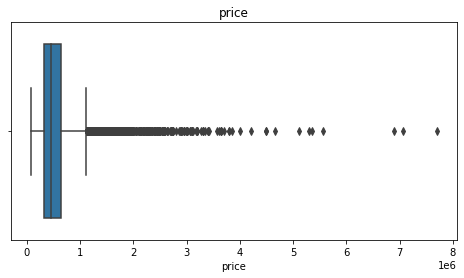

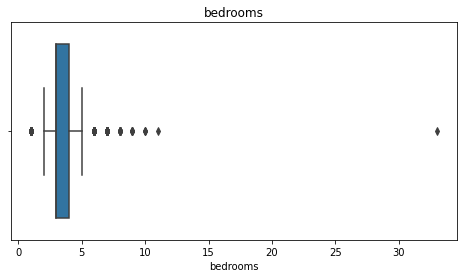

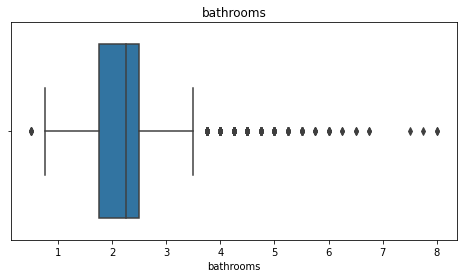

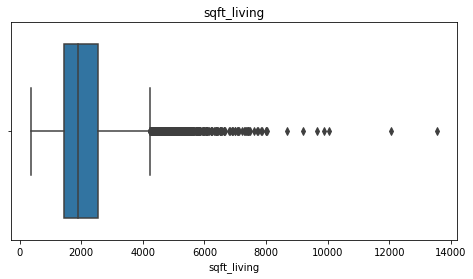

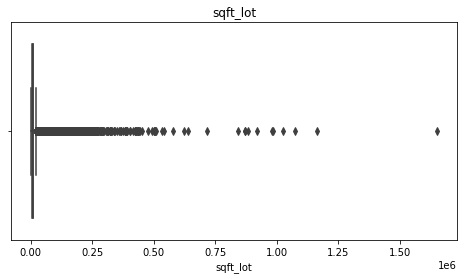

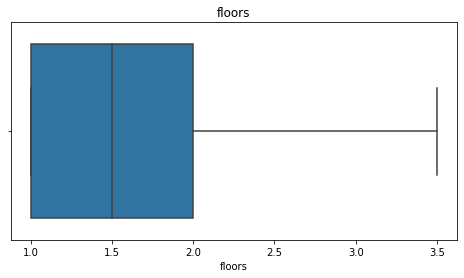

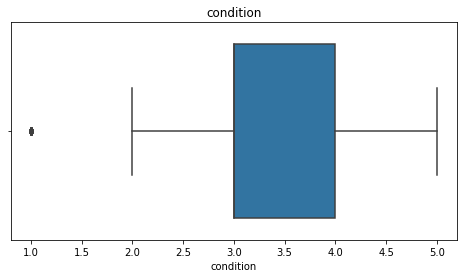

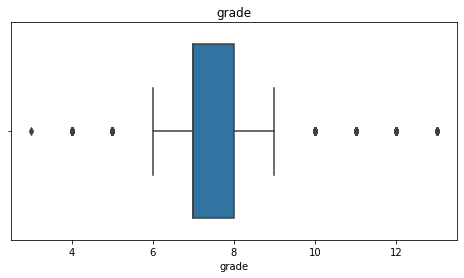

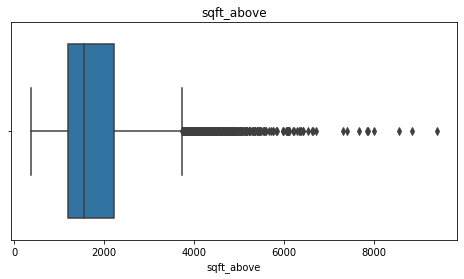

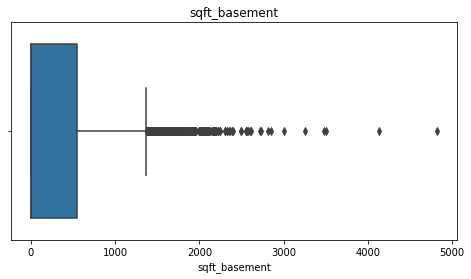

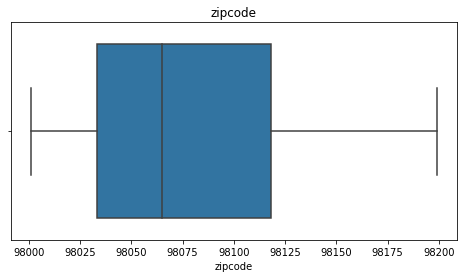

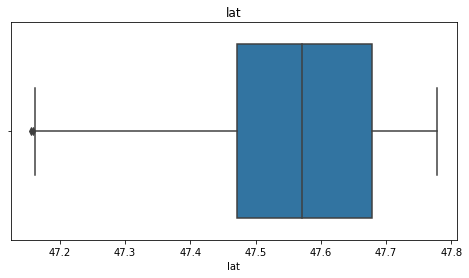

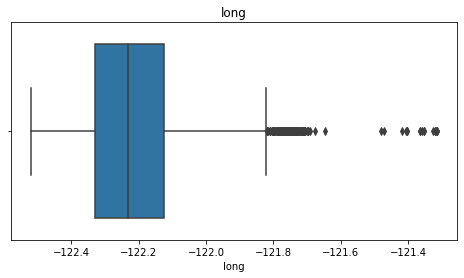

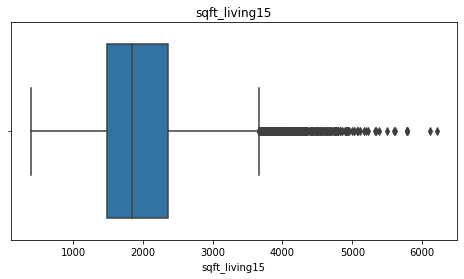

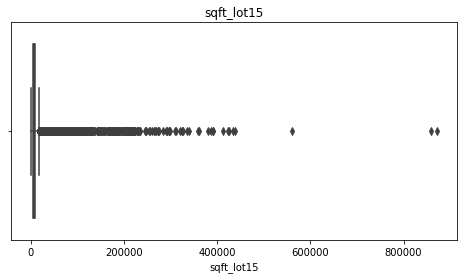

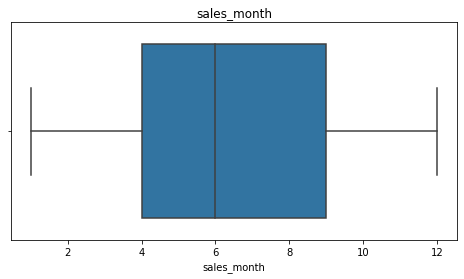

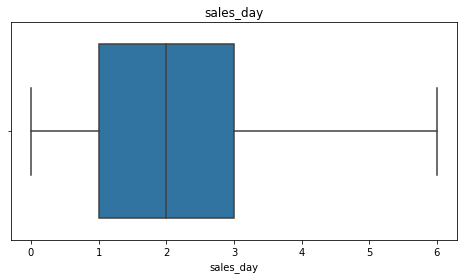

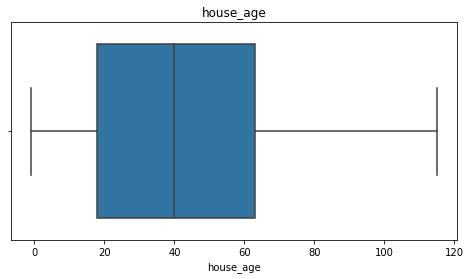

In [40]:
# Let's check out some boxplots as well

for column in df.columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(df[column])
    plt.title('{}'.format(column))
    plt.show()

In [41]:
df.shape

(21597, 18)

In [42]:
# Finding and removing outliers with a series of functions

for column in df.columns:
    df = remove_outliers_iqr(df, column)

df.shape

/Users/spags/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(15311, 18)

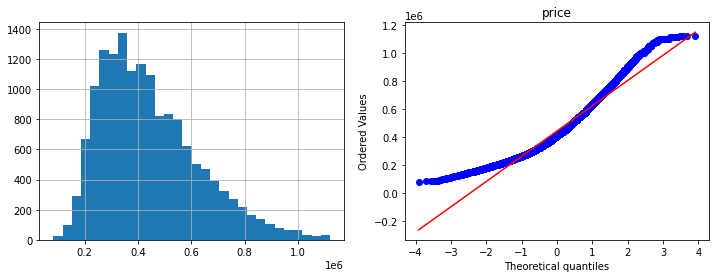

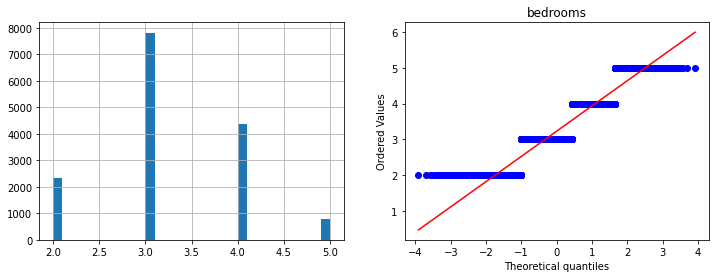

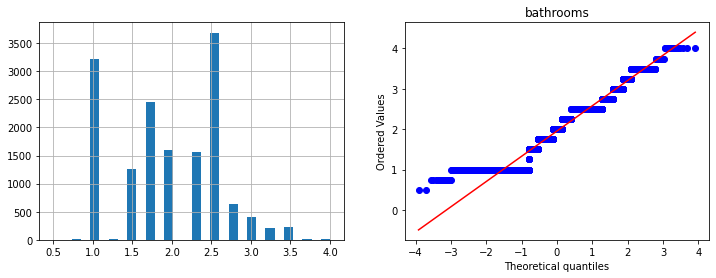

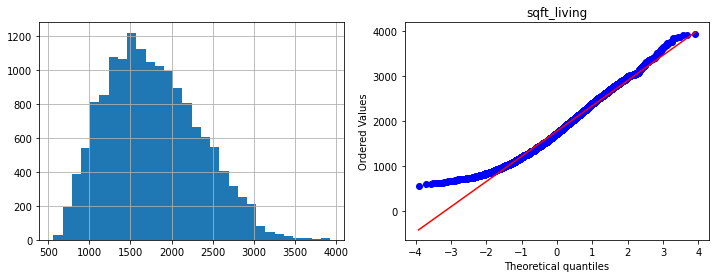

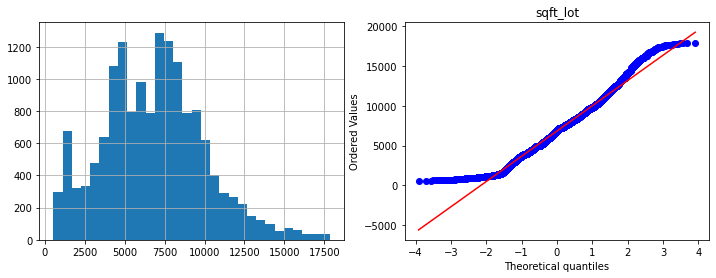

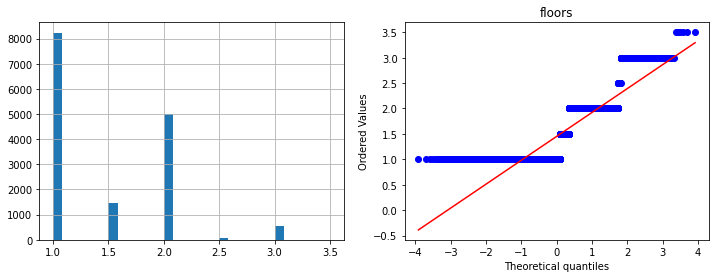

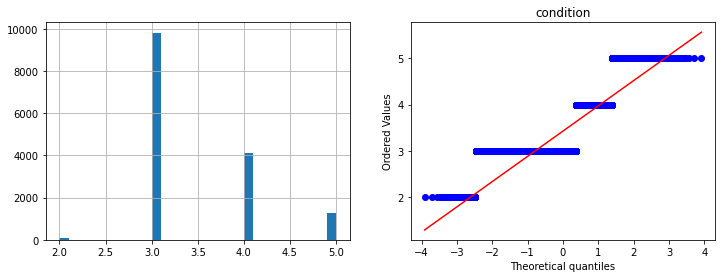

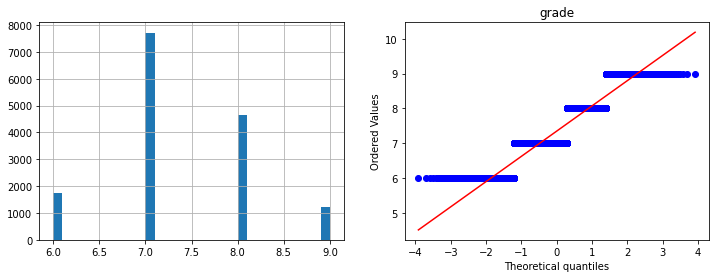

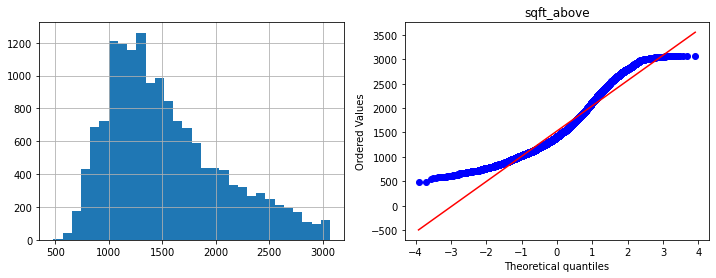

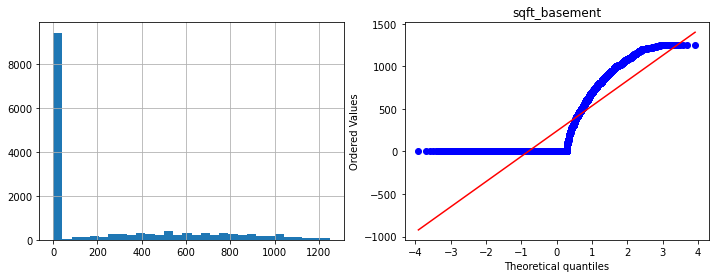

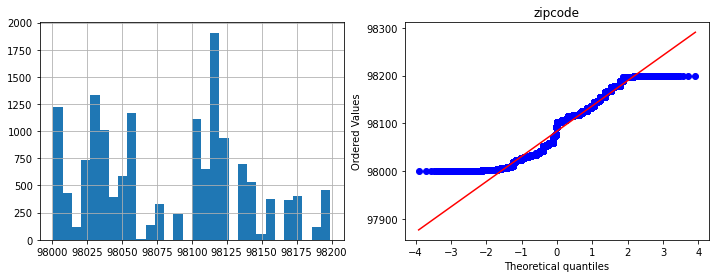

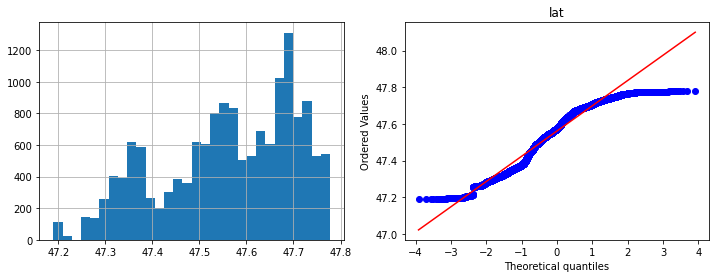

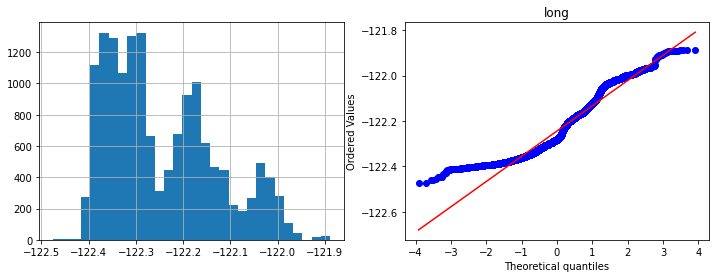

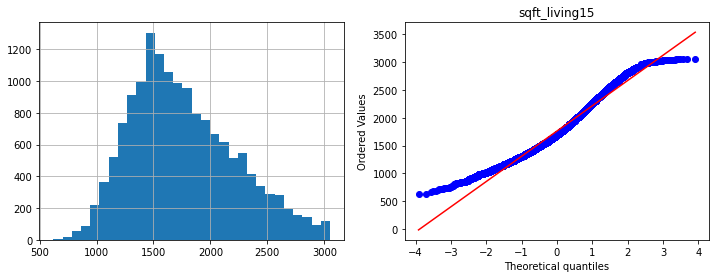

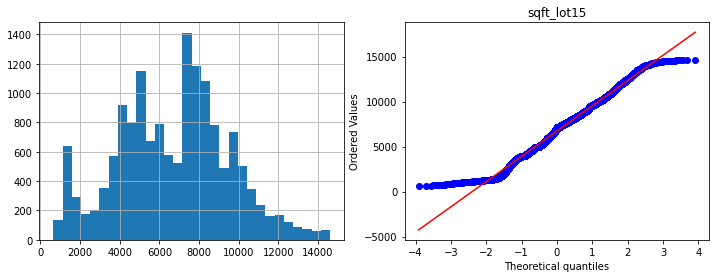

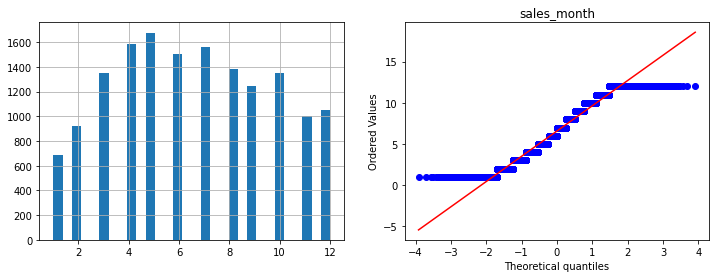

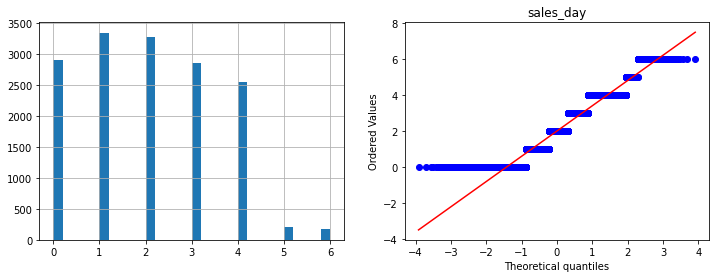

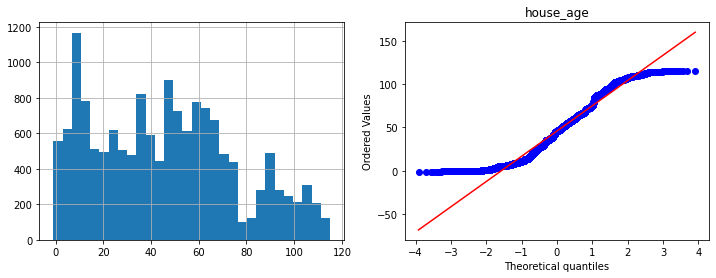

In [43]:
# Checking to see how we did

for column in df.columns:
    diagnostic_plots(df, column)

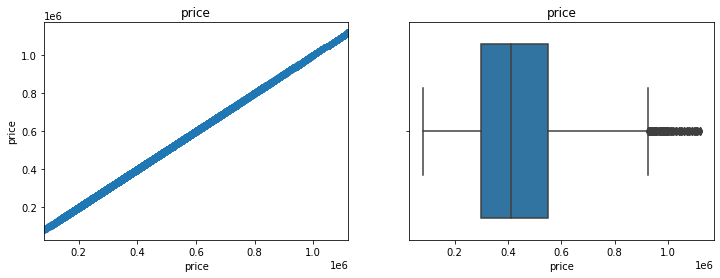

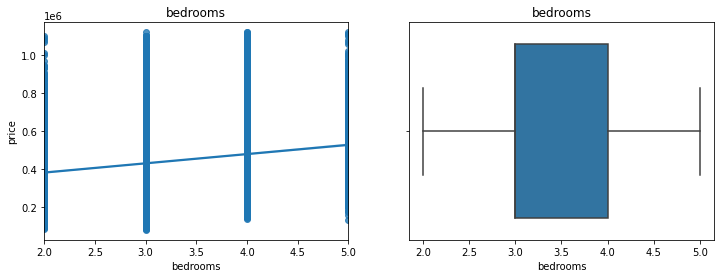

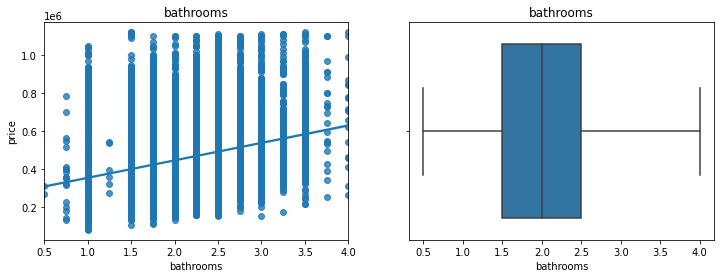

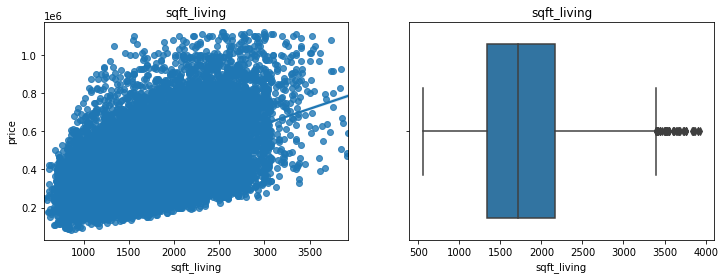

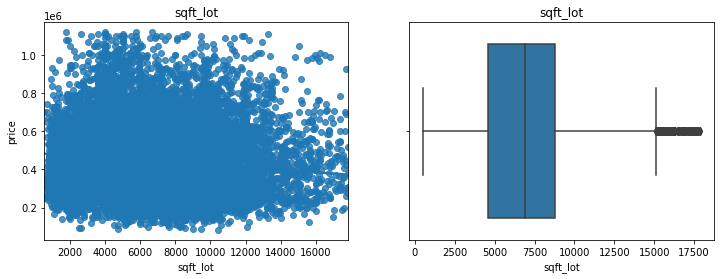

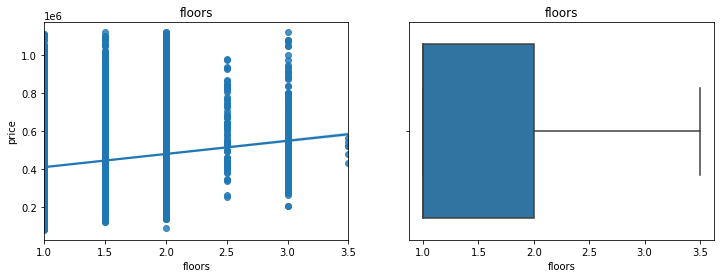

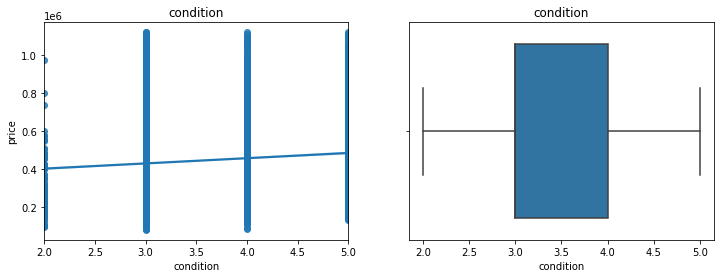

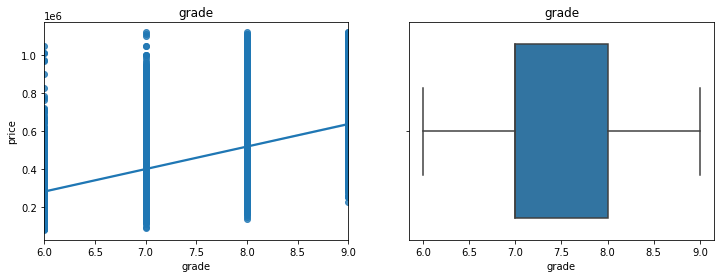

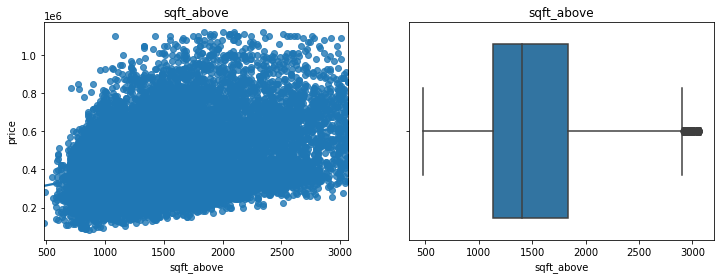

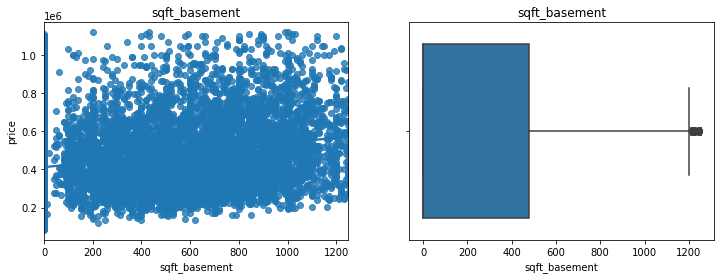

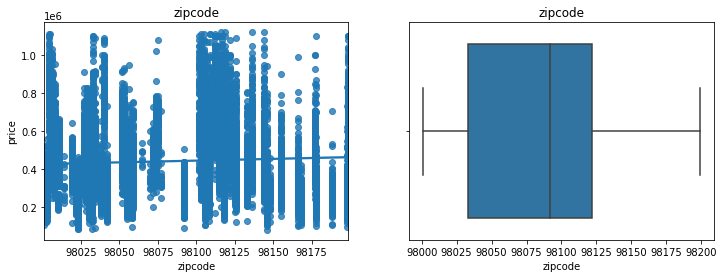

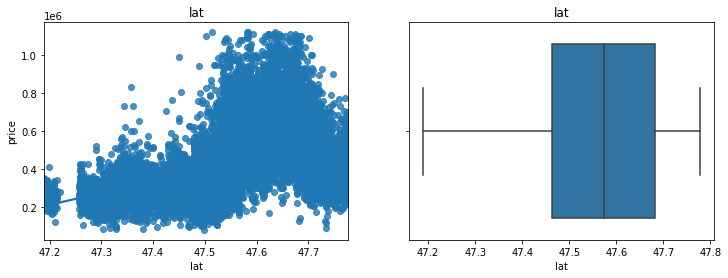

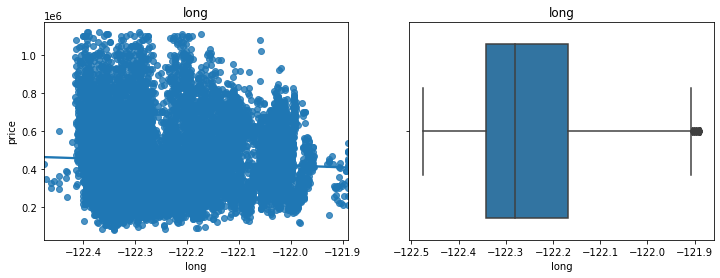

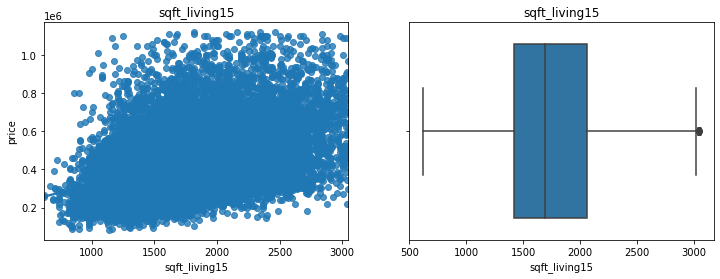

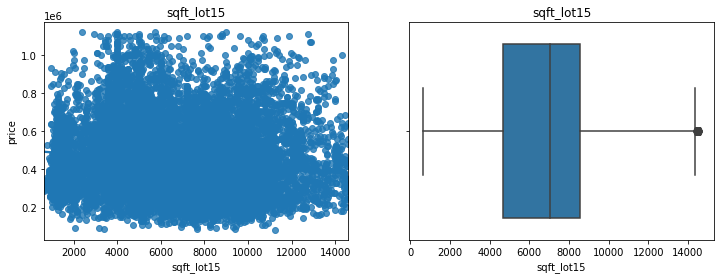

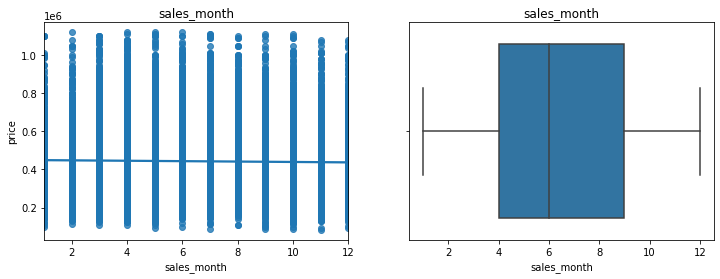

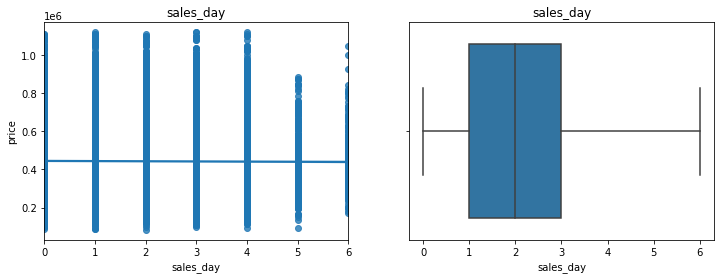

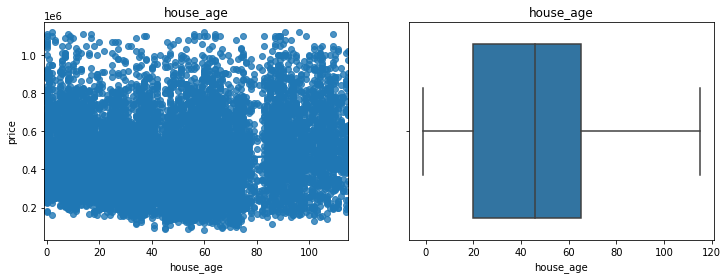

In [44]:
# Checking to see how we did

for column in df.columns:
    scatter_box_plots(df, column)

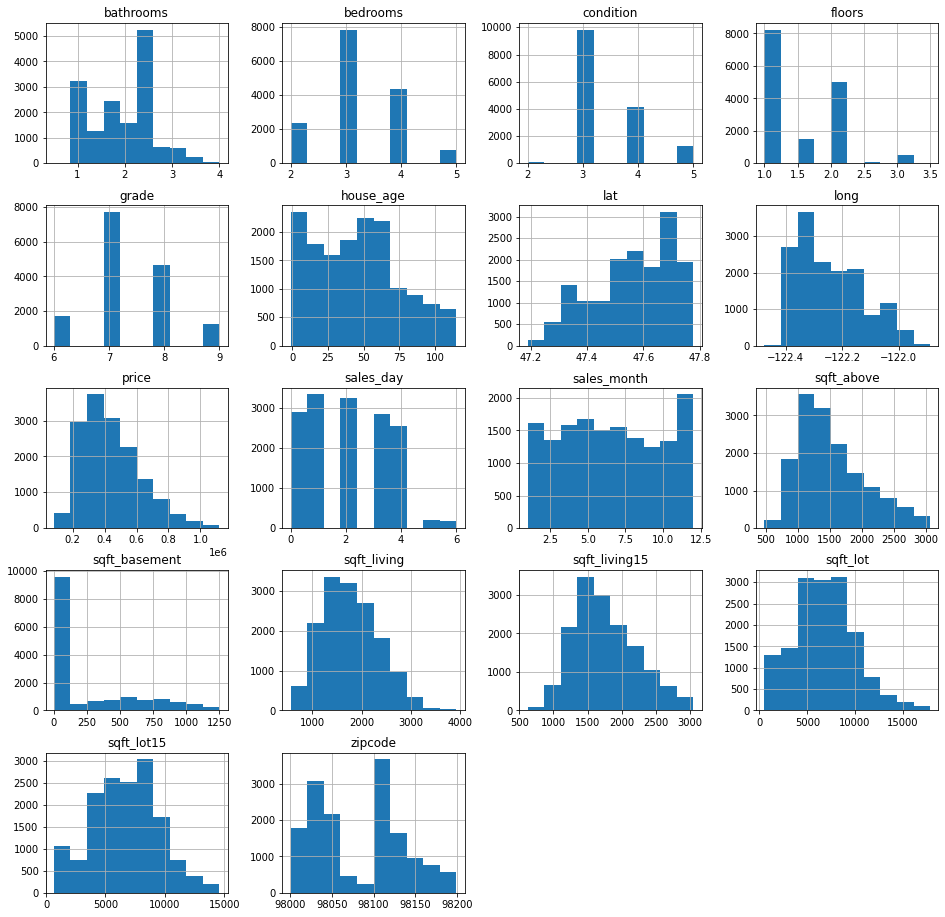

In [45]:
df.hist(figsize = (16, 16));

#### Outlier Removal

In [46]:
# I suspect some of these columns will become categorical
# sqft_basement and house_age still looks especially irregular, so let's see the value counts

print(df['sqft_basement'].value_counts())
print(df['house_age'].value_counts())

0.000      9414
500.000     186
600.000     175
700.000     172
800.000     160
           ... 
243.000       1
248.000       1
784.000       1
207.000       1
602.000       1
Name: sqft_basement, Length: 158, dtype: int64
 9     318
 11    301
 8     291
 7     279
 10    278
      ... 
 82     20
 79     19
 80     11
 81      9
-1       8
Name: house_age, Length: 117, dtype: int64


In [47]:
# Second round of outlier removal using the same method

# for column in df.columns:
#     df = remove_outliers_iqr(df, column)

# df.shape

In [48]:
# for column in df.columns:
#     diagnostic_plots(df, column)

In [49]:
# for column in df.columns:
#     scatter_box_plots(df, column)

### Could any of the columns be categorical?

>Thus far, all of the columns represent numerical data.  Let's investigate whether or not any of these could actually be categorical. After checking out the plots above, it seems as though the following columns could actually be categorical: <b> floors, waterfront, view, and was_renovated. </b>

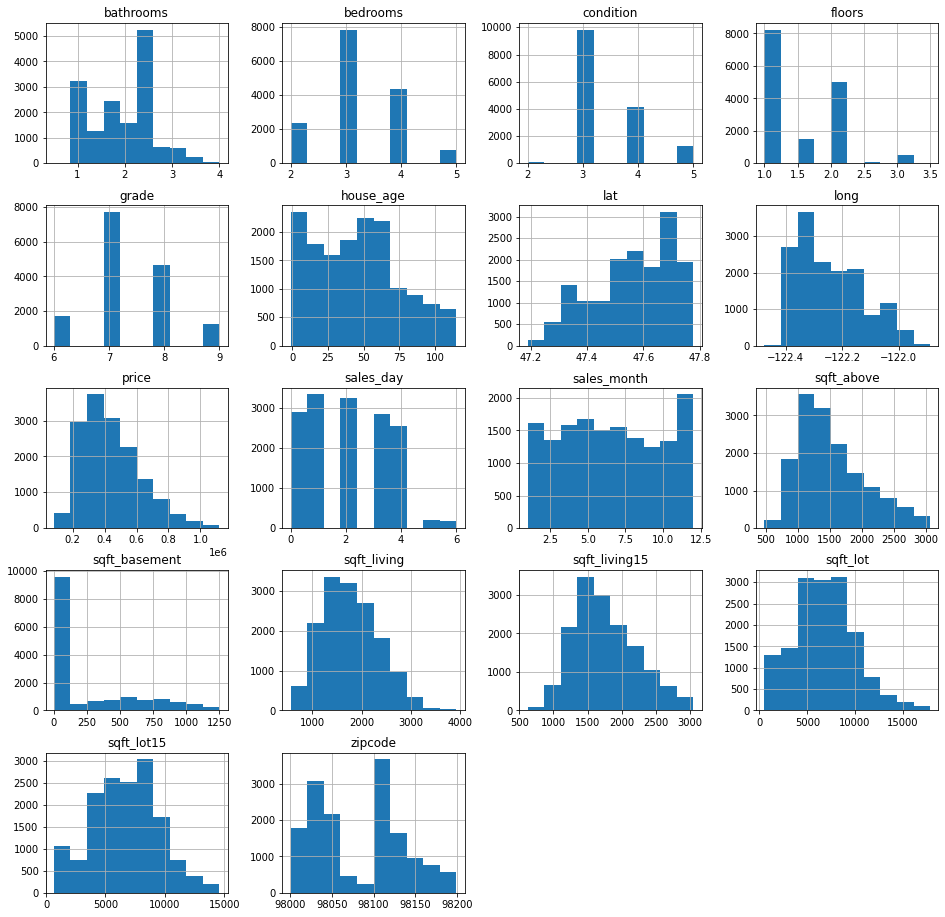

In [50]:
df.hist(figsize = (16,16));

>Checking out the plots above, there are a few columns that could be considered categorical.  Since sqft_basement looks so weird right now, let's see what's going on there first. 

In [51]:
df['sqft_basement'].value_counts()

0.000      9414
500.000     186
600.000     175
700.000     172
800.000     160
           ... 
243.000       1
248.000       1
784.000       1
207.000       1
602.000       1
Name: sqft_basement, Length: 158, dtype: int64

>Since there's a huge amount of 0's in this column, let's change this to a categorical column called "has_basement".

In [52]:
# Change the column to a boolean

for i in df['sqft_basement']:
    if i > 0:
        df['sqft_basement'].replace(i, 1, inplace = True)

# Change column name
df['has_basement'] = df['sqft_basement']
df['has_basement'] = df['has_basement'].astype(int)
df.drop(['sqft_basement'], axis = 1, inplace = True)

print(df['has_basement'].value_counts())
df.head()

0    9414
1    5897
Name: has_basement, dtype: int64


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,has_basement
0,221900.000,3,1.000,1180,5650,1.000,3,7,1180,98178,47.511,-122.257,1340,5650,10,0,59,0
1,538000.000,3,2.250,2570,7242,2.000,3,7,2170,98125,47.721,-122.319,1690,7639,12,1,63,1
2,180000.000,2,1.000,770,10000,1.000,3,6,770,98028,47.738,-122.233,2720,8062,2,2,82,0
3,604000.000,4,3.000,1960,5000,1.000,5,7,1050,98136,47.521,-122.393,1360,5000,12,1,49,1
4,510000.000,3,2.000,1680,8080,1.000,3,8,1680,98074,47.617,-122.045,1800,7503,2,2,28,0


>Zipcode should definitely be converted into an object as it represents specific locations and not a numerical value.  Other columns that should be converted to objects are <b> has_basement, condition, and grade.</b>

In [53]:
# Changing zipcode, has_basement, condition, and grade to an object

df['zipcode'] = df['zipcode'].astype('object') 
df['has_basement'] = df['has_basement'].astype('object') 
df['condition'] = df['condition'].astype('object') 
df['grade'] = df['grade'].astype('object') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15311 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15311 non-null  float64
 1   bedrooms       15311 non-null  int64  
 2   bathrooms      15311 non-null  float64
 3   sqft_living    15311 non-null  int64  
 4   sqft_lot       15311 non-null  int64  
 5   floors         15311 non-null  float64
 6   condition      15311 non-null  object 
 7   grade          15311 non-null  object 
 8   sqft_above     15311 non-null  int64  
 9   zipcode        15311 non-null  object 
 10  lat            15311 non-null  float64
 11  long           15311 non-null  float64
 12  sqft_living15  15311 non-null  int64  
 13  sqft_lot15     15311 non-null  int64  
 14  sales_month    15311 non-null  int64  
 15  sales_day      15311 non-null  int64  
 16  house_age      15311 non-null  int64  
 17  has_basement   15311 non-null  object 
dtypes: flo

In [54]:
# Separating Categorical and Numerical columns for future use

cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype != 'object']

print('Categorical Columns: {}'.format(str(cat_cols)))
print('Numerical Columns: {}'.format(str(num_cols)) )

Categorical Columns: ['condition', 'grade', 'zipcode', 'has_basement']
Numerical Columns: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sales_month', 'sales_day', 'house_age']


In [55]:
#one-hot encoding for category columns

df_dummies = df.copy()
df_dummies = pd.get_dummies(df, columns = cat_cols, drop_first = True)
print(df_dummies.shape)
df_dummies.head()

(15311, 89)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,sqft_living15,sqft_lot15,sales_month,sales_day,house_age,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,has_basement_1
0,221900.000,3,1.000,1180,5650,1.000,1180,47.511,-122.257,1340,5650,10,0,59,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.000,3,2.250,2570,7242,2.000,2170,47.721,-122.319,1690,7639,12,1,63,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,180000.000,2,1.000,770,10000,1.000,770,47.738,-122.233,2720,8062,2,2,82,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.000,4,3.000,1960,5000,1.000,1050,47.521,-122.393,1360,5000,12,1,49,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,510000.000,3,2.000,1680,8080,1.000,1680,47.617,-122.045,1800,7503,2,2,28,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Are there any multicolinearity issues?

In [56]:
# super helpful

# heatmap(df_dummies)

>The heatmap wasn't super helpful but the previous model had a warning indicating that there were, indeed, issues with multicolinearity.  We'll have to run feature selection methods to remove this issue.  First, we'll deal with correlated features and then give a Lasso feature selection a shot.  

#### Remove Correlated Features

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [58]:
# check for correlation first

def correlation(df, threshold):
    col_corr = set() # set of corellated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

In [59]:
# pull out correlated features

corr_features = correlation(df_dummies, 0.8)
print(len(corr_features))
corr_features

2


{'condition_4', 'sqft_lot15'}

In [60]:
# drop the columns with correlation

df_dummies.drop(labels = corr_features, axis = 1, inplace = True)
df_dummies

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,lat,long,sqft_living15,sales_month,sales_day,house_age,condition_3,condition_5,grade_7,grade_8,grade_9,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,has_basement_1
0,221900.000,3,1.000,1180,5650,1.000,1180,47.511,-122.257,1340,10,0,59,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.000,3,2.250,2570,7242,2.000,2170,47.721,-122.319,1690,12,1,63,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,180000.000,2,1.000,770,10000,1.000,770,47.738,-122.233,2720,2,2,82,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.000,4,3.000,1960,5000,1.000,1050,47.521,-122.393,1360,12,1,49,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,510000.000,3,2.000,1680,8080,1.000,1680,47.617,-122.045,1800,2,2,28,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.000,3,2.500,1530,1131,3.000,1530,47.699,-122.346,1530,5,2,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.000,4,2.500,2310,5813,2.000,2310,47.511,-122.362,1830,2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21594,402101.000,2,0.750,1020,1350,2.000,1020,47.594,-122.299,1020,6,0,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21595,400000.000,3,2.500,1600,2388,2.000,1600,47.535,-122.069,1410,1,4,11,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Remove Features using VIF

In [61]:
# Create VIF scores for each column

x = df_dummies.drop('price', axis = 1)
x = sm.add_constant(x)
vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif_results = pd.Series(dict(zip(x.columns, vif)))
vif_results

const            71109162.218
bedrooms                1.743
bathrooms               2.859
sqft_living            11.315
sqft_lot                2.215
                     ...     
zipcode_98178           4.230
zipcode_98188           2.025
zipcode_98198           2.362
zipcode_98199           9.705
has_basement_1          3.916
Length: 87, dtype: float64

In [62]:
#Separate the bad VIF scores

threshold = 6
bad_vif = list(vif_results[vif_results > threshold].index)
if 'const' in bad_vif:
    bad_vif.remove('const')
bad_vif

['sqft_living',
 'sqft_above',
 'lat',
 'long',
 'zipcode_98006',
 'zipcode_98008',
 'zipcode_98011',
 'zipcode_98019',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98056',
 'zipcode_98059',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98115',
 'zipcode_98116',
 'zipcode_98117',
 'zipcode_98118',
 'zipcode_98119',
 'zipcode_98122',
 'zipcode_98125',
 'zipcode_98126',
 'zipcode_98133',
 'zipcode_98144',
 'zipcode_98155',
 'zipcode_98177',
 'zipcode_98199']

In [63]:
# Best practice is to keep the zipcode columns intact for now so let's remove the others

df_dummies.drop(['sqft_living', 'sqft_above', 'lat', 'long'], axis = 1, inplace = True)
df_dummies

,price,bedrooms,bathrooms,sqft_lot,floors,sqft_living15,sales_month,sales_day,house_age,condition_3,condition_5,grade_7,grade_8,grade_9,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,has_basement_1
0,221900.000,3,1.000,5650,1.000,1340,10,0,59,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,538000.000,3,2.250,7242,2.000,1690,12,1,63,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,180000.000,2,1.000,10000,1.000,2720,2,2,82,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,604000.000,4,3.000,5000,1.000,1360,12,1,49,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,510000.000,3,2.000,8080,1.000,1800,2,2,28,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.000,3,2.500,1131,3.000,1530,5,2,5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21593,400000.000,4,2.500,5813,2.000,1830,2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21594,402101.000,2,0.750,1350,2.000,1020,6,0,5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
21595,400000.000,3,2.500,2388,2.000,1410,1,4,11,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Remove Quasi-Constant Features

In [64]:
# Filtering out Quasi-Constant Features using the variance threshold.  0.01 should be equivalent to 99%
# Checking out the amount of keepers

sel = VarianceThreshold(threshold = 0.01)
sel.fit(df_dummies)
sum(sel.get_support())

60

In [65]:
# Checking out the keepers

features_to_keep = df_dummies.columns[sel.get_support()]
features_to_keep

Index(['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_living15',
       'sales_month', 'sales_day', 'house_age', 'condition_3', 'condition_5',
       'grade_7', 'grade_8', 'grade_9', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98006', 'zipcode_98008', 'zipcode_98023', 'zipcode_98027',
       'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98042',
       'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 'zipcode_98056',
       'zipcode_98058', 'zipcode_98059', 'zipcode_98074', 'zipcode_98092',
       'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107',
       'zipcode_98108', 'zipcode_98115', 'zipcode_98116', 'zipcode_98117',
       'zipcode_98118', 'zipcode_98122', 'zipcode_98125', 'zipcode_98126',
       'zipcode_98133', 'zipcode_98136', 'zipcode_98144', 'zipcode_98146',
       'zipcode_98155', 'zipcode_98166', 'zipcode_98168', 'zipcode_98177',
       'zipcode_98

In [66]:
# Remove the non-keepers

df_dummies = sel.transform(df_dummies)

In [67]:
# Return to this to a dataframe

df_dummies = pd.DataFrame(df_dummies)
df_dummies.columns = features_to_keep
print(df_dummies.shape)
df_dummies.head()

(15311, 60)


,price,bedrooms,bathrooms,sqft_lot,floors,sqft_living15,sales_month,sales_day,house_age,condition_3,condition_5,grade_7,grade_8,grade_9,zipcode_98002,zipcode_98003,zipcode_98006,zipcode_98008,zipcode_98023,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98042,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98074,zipcode_98092,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98198,zipcode_98199,has_basement_1
0,221900.000,3.000,1.000,5650.000,1.000,1340.000,10.000,0.000,59.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
1,538000.000,3.000,2.250,7242.000,2.000,1690.000,12.000,1.000,63.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2,180000.000,2.000,1.000,10000.000,1.000,2720.000,2.000,2.000,82.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,604000.000,4.000,3.000,5000.000,1.000,1360.000,12.000,1.000,49.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
4,510000.000,3.000,2.000,8080.000,1.000,1800.000,2.000,2.000,28.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


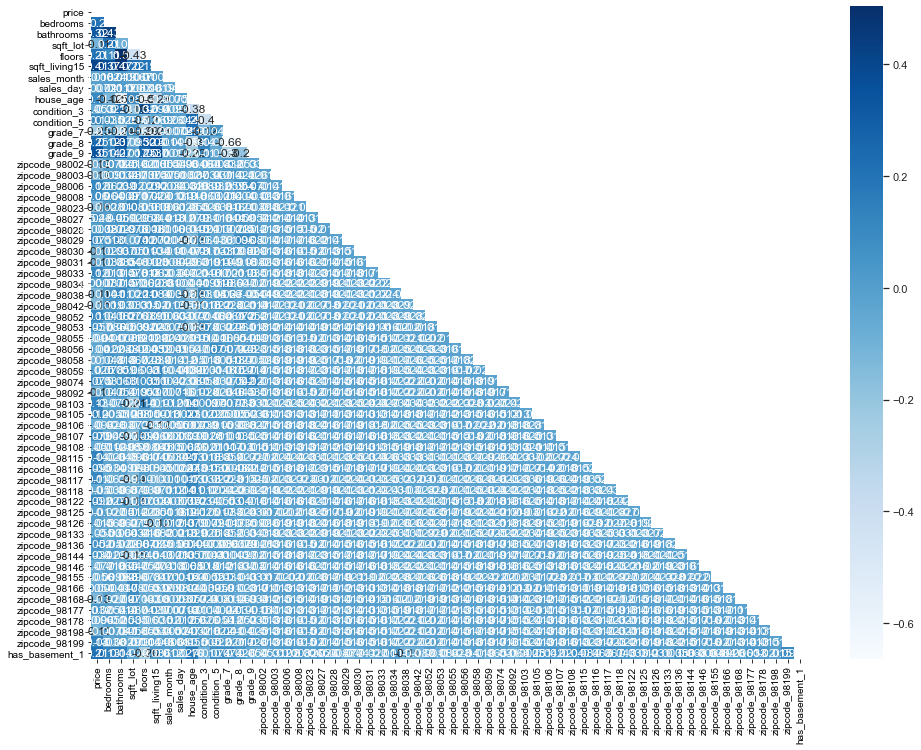

In [68]:
# Let's see an updated heatmap

heatmap(df_dummies)

## Model

In [69]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})

### Baseline Model
>Let's throw down a baseline model to see where we're at so far.  

In [70]:
# Running a baseline model 

features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     554.7
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:30:28   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15251   BIC:                         3.978e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.013e+04   7863.204      2.560      0.010    4714.428    3.55e+04
bedrooms        1.122e+04   1325.381      8.464      0.000    8620.549    1.38e+04
bathrooms       4.004e+04   2065.121     19.390      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0561      0.366     -2.883      0.004      -1.774      -0.338
floors          2.256e+04   2456.390      9.183      0.000    1.77e+04    2.74e+04
sqft_living15     89.0424      2.543     35.020      0.000      84.059      94.026
sales_month    -2039.2723    270.066     -7.551      0.000   -2568.635   -1509.910
sales_day       -872.1057    578.159     -1.508      0.131   -2005.367     261.156
house_age       1847.0171     44.921     41.117      0.000    1758.967    1935.068
condition_3    -2.005e+04   2123.380     -9.444      0.000   -2.42e+04   -1.59e+04
condition_5     2.349e+04   3407.004      6.895      0.000    1.68e+04    3.02e+04
grade_7         5.682e+04   3102.896     18.312      0.000    5.07e+04    6.29e+04
grade_8         1.347e+05   3855.750     34.944      0.000    1.27e+05    1.42e+05
grade_9         2.524e+05   5097.622     49.519      0.000    2.42e+05    2.62e+05
zipcode_98002  -1.619e+05   8337.187    -19.413      0.000   -1.78e+05   -1.46e+05
zipcode_98003  -1.804e+05   7106.737    -25.386      0.000   -1.94e+05   -1.66e+05
zipcode_98006   4.075e+04   7163.537      5.688      0.000    2.67e+04    5.48e+04
zipcode_98008   3.471e+04   7287.420      4.763      0.000    2.04e+04     4.9e+04
zipcode_98023  -2.043e+05   5720.562    -35.718      0.000   -2.16e+05   -1.93e+05
zipcode_98027   1.704e+04   8144.714      2.092      0.036    1077.085     3.3e+04
zipcode_98028   -6.29e+04   7420.590     -8.477      0.000   -7.74e+04   -4.84e+04
zipcode_98029   1.896e+04   6992.880      2.712      0.007    5256.381    3.27e+04
zipcode_98030  -1.742e+05   7314.204    -23.816      0.000   -1.89e+05    -1.6e+05
zipcode_98031  -1.727e+05   7178.165    -24.059      0.000   -1.87e+05   -1.59e+05
zipcode_98033   1.064e+05   6583.473     16.157      0.000    9.35e+04    1.19e+05
zipcode_98034  -7004.6435   5413.827     -1.294      0.196   -1.76e+04    3607.104
zipcode_98038   -1.32e+05   5590.884    -23.610      0.000   -1.43e+05   -1.21e+05
zipcode_98042  -1.583e+05   5799.671    -27.296      0.000    -1.7e+05   -1.47e+05
zipcode_98052    4.27e+04   5742.084      7.437      0.000    3.14e+04     5.4e+04
zipcode_98053   1.143e+05   8071.278     14.157      0.000    9.84e+04     1.3e+05
zipcode_98055  -1.559e+05   7444.554    -20.943      0.000   -1.71e+05   -1.41e+05
zipcode_98056  -8.287e+04   6466.518    -12.816      0.000   -9.55e+04   -7.02e+04
zipcode_98058  -1.537e+05   6059.290    -25.362      0.000   -1.66e+05   -1.42e+05
zipcode_98059  -8.622e+04   6562.762    -13.138      0.000   -9.91e+04   -7.34e+04
zipcode_9807

#### Dropping Insignificant Coefficients


> We want to drop columns that show an insignifcant p-value.  Therefore, the following columns have to go: <b>, sales_day, zipcode_98034, zipcode_98074, zipcode_98144, zipcode_98177.

In [71]:
np.set_printoptions(suppress=True)

In [72]:
df_dummies.drop(['sales_day', 'zipcode_98034', 'zipcode_98074', 'zipcode_98144', 'zipcode_98177'], 
                axis = 1, inplace = True)

### Secondary Model

In [73]:
# Let's see how that worked

features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     605.8
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:30:28   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15256   BIC:                         3.977e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.623e+04   7603.789      2.135      0.033    1330.320    3.11e+04
bedrooms        1.115e+04   1324.743      8.418      0.000    8554.673    1.37e+04
bathrooms       4.002e+04   2064.060     19.388      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0422      0.358     -2.908      0.004      -1.745      -0.340
floors          2.289e+04   2444.961      9.363      0.000    1.81e+04    2.77e+04
sqft_living15     89.1077      2.539     35.094      0.000      84.131      94.085
sales_month    -2023.1685    269.857     -7.497      0.000   -2552.121   -1494.216
house_age       1848.4206     44.391     41.640      0.000    1761.409    1935.432
condition_3    -2.003e+04   2122.649     -9.436      0.000   -2.42e+04   -1.59e+04
condition_5     2.352e+04   3406.653      6.905      0.000    1.68e+04    3.02e+04
grade_7         5.671e+04   3102.228     18.281      0.000    5.06e+04    6.28e+04
grade_8         1.347e+05   3852.353     34.959      0.000    1.27e+05    1.42e+05
grade_9         2.527e+05   5087.930     49.660      0.000    2.43e+05    2.63e+05
zipcode_98002  -1.603e+05   8226.929    -19.486      0.000   -1.76e+05   -1.44e+05
zipcode_98003  -1.787e+05   6976.088    -25.619      0.000   -1.92e+05   -1.65e+05
zipcode_98006   4.232e+04   7039.082      6.012      0.000    2.85e+04    5.61e+04
zipcode_98008   3.662e+04   7160.276      5.114      0.000    2.26e+04    5.07e+04
zipcode_98023  -2.027e+05   5556.090    -36.480      0.000   -2.14e+05   -1.92e+05
zipcode_98027   1.845e+04   8027.878      2.298      0.022    2709.974    3.42e+04
zipcode_98028  -6.138e+04   7298.438     -8.410      0.000   -7.57e+04   -4.71e+04
zipcode_98029   2.028e+04   6860.978      2.956      0.003    6830.254    3.37e+04
zipcode_98030  -1.726e+05   7189.010    -24.003      0.000   -1.87e+05   -1.58e+05
zipcode_98031  -1.711e+05   7050.217    -24.268      0.000   -1.85e+05   -1.57e+05
zipcode_98033    1.08e+05   6447.508     16.752      0.000    9.54e+04    1.21e+05
zipcode_98038  -1.306e+05   5426.733    -24.060      0.000   -1.41e+05    -1.2e+05
zipcode_98042  -1.567e+05   5640.909    -27.771      0.000   -1.68e+05   -1.46e+05
zipcode_98052   4.424e+04   5582.596      7.924      0.000    3.33e+04    5.52e+04
zipcode_98053   1.159e+05   7953.435     14.570      0.000       1e+05    1.31e+05
zipcode_98055  -1.542e+05   7320.701    -21.063      0.000   -1.69e+05    -1.4e+05
zipcode_98056  -8.142e+04   6325.144    -12.872      0.000   -9.38e+04    -6.9e+04
zipcode_98058  -1.519e+05   5907.180    -25.721      0.000   -1.64e+05    -1.4e+05
zipcode_98059  -8.455e+04   6426.546    -13.157      0.000   -9.72e+04    -7.2e+04
zipcode_98092  -2.039e+05   7118.716    -28.640      0.000   -2.18e+05    -1.9e+05
zipcode_98103   7.724e+04   5132.615     15.048      0.000    6.72e+04    8.73e+04
zipcode_9810

In [74]:
# Checking the mean of residuals

model.resid.mean()

-1.3747515844088845e-07

<Figure size 864x432 with 0 Axes>

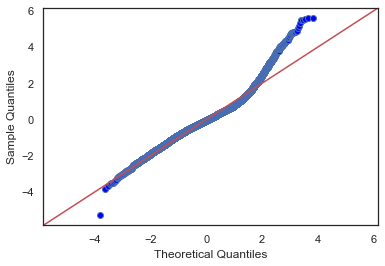

In [75]:
# qqplot to check for linearity 

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

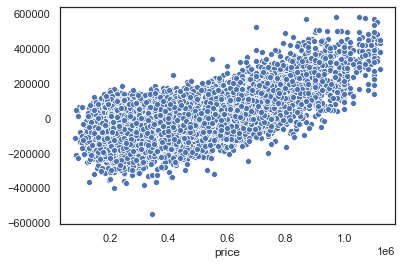

In [76]:
# Scatter plot to check homoscedasticity 

sns.scatterplot(df_dummies['price'], model.resid, );

### Model Validation with Scikit-Learn

In [136]:
# Separate into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], 
                                                    test_size = 0.3, random_state = 30)

print(len(X_train), len(X_test), len(y_train), len(y_test))

10717 4594 10717 4594


In [137]:
# Run scikit-learn Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report

# Fit the model to train data
linreg = LinearRegression()
linreg.fit(X_train, y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [138]:
# Get predictions 
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [139]:
# Train & Test Residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [140]:
X = df_dummies.drop('price', axis = 1)
y = df_dummies['price']

In [141]:
# Find the Mean Squared Error

from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 4.820033991630448e-21
Test Mean Squarred Error: 4.770276049107547e-21


In [142]:
# Get Cross Validation Score

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results

array([1.10447800e+10, 1.10068041e+10, 1.06565687e+10, 1.05590360e+10,
       1.13405211e+10])

In [143]:
#Get the mean of the Cross Validation Scores

print('Cross Validation Score: {}'.format(cv_5_results.mean()))

Cross Validation Score: 10921541982.88058


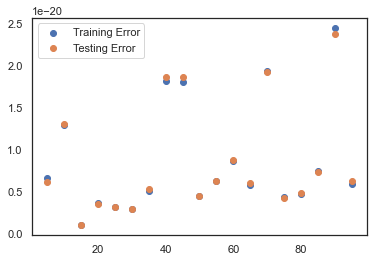

In [144]:
import random
random.seed(110)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend();

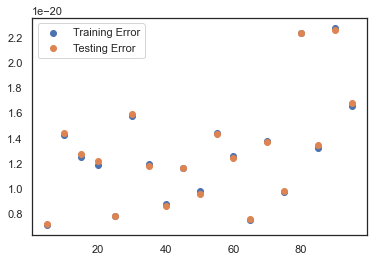

In [145]:
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend();

### Model Validation with Statsmodels

In [87]:
# Separate into train and test sets

X_train, X_test, y_train, y_test = train_test_split(df_dummies, df_dummies['price'], 
                                                    test_size = 0.3, random_state = 30)

print(len(X_train), len(X_test), len(y_train), len(y_test))

10717 4594 10717 4594


#### Run Train Set

In [88]:
# Run a training model

features = '+'.join(X_train.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     412.6
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:30:39   Log-Likelihood:            -1.3907e+05
No. Observations:               10717   AIC:                         2.783e+05
Df Residuals:                   10662   BIC:                         2.787e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2.445e+04   9227.886      2.649      0.008    6357.667    4.25e+04
bedrooms         1.19e+04   1594.951      7.461      0.000    8773.257     1.5e+04
bathrooms       4.007e+04   2496.469     16.049      0.000    3.52e+04     4.5e+04
sqft_lot          -1.3385      0.436     -3.067      0.002      -2.194      -0.483
floors          1.801e+04   2987.960      6.029      0.000    1.22e+04    2.39e+04
sqft_living15     89.2401      3.071     29.063      0.000      83.221      95.259
sales_month    -2191.5567    324.443     -6.755      0.000   -2827.526   -1555.588
house_age       1800.0317     53.903     33.394      0.000    1694.371    1905.692
condition_3    -2.096e+04   2562.220     -8.179      0.000    -2.6e+04   -1.59e+04
condition_5     2.212e+04   4132.212      5.353      0.000     1.4e+04    3.02e+04
grade_7         6.031e+04   3731.196     16.164      0.000     5.3e+04    6.76e+04
grade_8         1.389e+05   4636.209     29.956      0.000     1.3e+05    1.48e+05
grade_9         2.523e+05   6127.143     41.184      0.000     2.4e+05    2.64e+05
zipcode_98002   -1.58e+05   9528.401    -16.583      0.000   -1.77e+05   -1.39e+05
zipcode_98003  -1.793e+05   8679.968    -20.651      0.000   -1.96e+05   -1.62e+05
zipcode_98006   3.877e+04   8449.189      4.589      0.000    2.22e+04    5.53e+04
zipcode_98008   3.907e+04   8589.658      4.548      0.000    2.22e+04    5.59e+04
zipcode_98023  -2.054e+05   6573.477    -31.250      0.000   -2.18e+05   -1.93e+05
zipcode_98027   2.044e+04   9487.473      2.154      0.031    1839.351     3.9e+04
zipcode_98028  -5.729e+04   8853.167     -6.471      0.000   -7.46e+04   -3.99e+04
zipcode_98029   2.028e+04   7993.944      2.537      0.011    4609.421    3.59e+04
zipcode_98030  -1.695e+05   9065.651    -18.694      0.000   -1.87e+05   -1.52e+05
zipcode_98031  -1.735e+05   8534.915    -20.323      0.000    -1.9e+05   -1.57e+05
zipcode_98033   9.707e+04   8025.215     12.096      0.000    8.13e+04    1.13e+05
zipcode_98038  -1.325e+05   6454.074    -20.526      0.000   -1.45e+05    -1.2e+05
zipcode_98042  -1.612e+05   6822.752    -23.624      0.000   -1.75e+05   -1.48e+05
zipcode_98052   4.559e+04   6625.025      6.882      0.000    3.26e+04    5.86e+04
zipcode_98053   1.135e+05   9595.215     11.830      0.000    9.47e+04    1.32e+05
zipcode_98055  -1.623e+05   8749.730    -18.551      0.000   -1.79e+05   -1.45e+05
zipcode_98056  -8.212e+04   7782.010    -10.553      0.000   -9.74e+04   -6.69e+04
zipcode_98058  -1.527e+05   7159.178    -21.335      0.000   -1.67e+05   -1.39e+05
zipcode_98059  -8.667e+04   7942.819    -10.912      0.000   -1.02e+05   -7.11e+04
zipcode_98092  -2.007e+05   8367.926    -23.986      0.000   -2.17e+05   -1.84e+05
zipcode_98103   7.836e+04   6135.801     12.772      0.000    6.63e+04    9.04e+04
zipcode_9810

<Figure size 864x432 with 0 Axes>

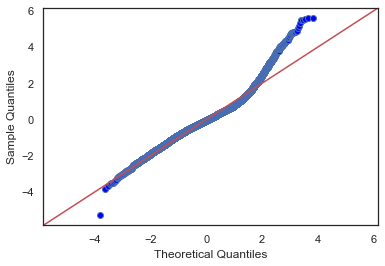

In [118]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

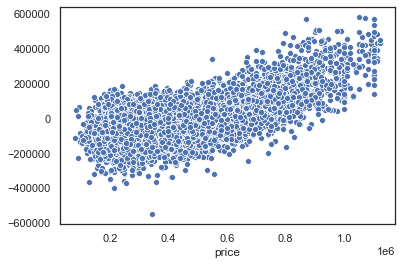

In [119]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_train['price'], model.resid);

#### Run Test Set

In [91]:
# Run a model on the test set

features = '+'.join(X_test.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, X_test).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     194.9
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:30:39   Log-Likelihood:                -59500.
No. Observations:                4594   AIC:                         1.191e+05
Df Residuals:                    4539   BIC:                         1.195e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        308.8782   1.35e+04      0.023      0.982   -2.61e+04    2.67e+04
bedrooms        9579.0586   2390.937      4.006      0.000    4891.659    1.43e+04
bathrooms       3.968e+04   3689.383     10.755      0.000    3.24e+04    4.69e+04
sqft_lot          -0.5989      0.631     -0.950      0.342      -1.835       0.637
floors          3.302e+04   4264.851      7.743      0.000    2.47e+04    4.14e+04
sqft_living15     88.9707      4.547     19.567      0.000      80.057      97.885
sales_month    -1608.1670    488.402     -3.293      0.001   -2565.673    -650.661
house_age       1952.7038     78.572     24.852      0.000    1798.664    2106.744
condition_3    -1.831e+04   3810.400     -4.805      0.000   -2.58e+04   -1.08e+04
condition_5     2.669e+04   6039.906      4.419      0.000    1.49e+04    3.85e+04
grade_7         4.833e+04   5609.420      8.617      0.000    3.73e+04    5.93e+04
grade_8         1.254e+05   6961.866     18.015      0.000    1.12e+05    1.39e+05
grade_9         2.545e+05   9184.665     27.704      0.000    2.36e+05    2.72e+05
zipcode_98002   -1.68e+05   1.64e+04    -10.241      0.000      -2e+05   -1.36e+05
zipcode_98003  -1.764e+05   1.17e+04    -15.055      0.000   -1.99e+05   -1.53e+05
zipcode_98006   5.024e+04   1.27e+04      3.944      0.000    2.53e+04    7.52e+04
zipcode_98008   3.061e+04    1.3e+04      2.359      0.018    5168.449     5.6e+04
zipcode_98023  -1.945e+05   1.04e+04    -18.647      0.000   -2.15e+05   -1.74e+05
zipcode_98027   1.311e+04   1.51e+04      0.867      0.386   -1.65e+04    4.27e+04
zipcode_98028  -6.947e+04   1.29e+04     -5.390      0.000   -9.47e+04   -4.42e+04
zipcode_98029   1.968e+04   1.34e+04      1.463      0.143   -6684.048     4.6e+04
zipcode_98030  -1.776e+05   1.18e+04    -15.050      0.000   -2.01e+05   -1.54e+05
zipcode_98031  -1.653e+05   1.25e+04    -13.215      0.000    -1.9e+05   -1.41e+05
zipcode_98033   1.284e+05   1.08e+04     11.842      0.000    1.07e+05     1.5e+05
zipcode_98038   -1.26e+05      1e+04    -12.551      0.000   -1.46e+05   -1.06e+05
zipcode_98042   -1.46e+05      1e+04    -14.543      0.000   -1.66e+05   -1.26e+05
zipcode_98052   3.957e+04   1.04e+04      3.804      0.000    1.92e+04       6e+04
zipcode_98053   1.221e+05   1.42e+04      8.595      0.000    9.43e+04     1.5e+05
zipcode_98055   -1.35e+05   1.34e+04    -10.098      0.000   -1.61e+05   -1.09e+05
zipcode_98056  -8.052e+04   1.09e+04     -7.413      0.000   -1.02e+05   -5.92e+04
zipcode_98058  -1.503e+05   1.05e+04    -14.373      0.000   -1.71e+05    -1.3e+05
zipcode_98059  -7.916e+04   1.09e+04     -7.240      0.000   -1.01e+05   -5.77e+04
zipcode_98092  -2.133e+05   1.36e+04    -15.705      0.000    -2.4e+05   -1.87e+05
zipcode_98103   7.431e+04   9395.490      7.909      0.000    5.59e+04    9.27e+04
zipcode_9810

<Figure size 864x432 with 0 Axes>

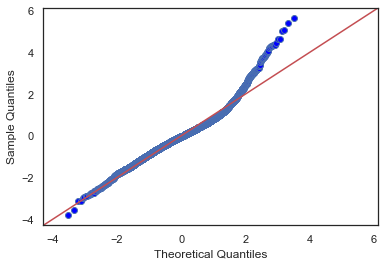

In [92]:
# QQ Plotting for linearity

fig = plt.figure(figsize = (12,6))
fig = sm.graphics.qqplot(model.resid,fit=True, line='45');

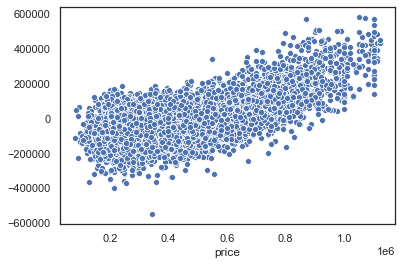

In [120]:
# Scatter plot for homoescedasticity

sns.scatterplot(X_train['price'], model.resid);

#### Model Validation

In [125]:
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [129]:
X = df_dummies.drop(['price'], axis = 1)
y = df_dummies['price']

In [130]:
print(cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2'))
print(cross_val_score(LinearRegression(),X, y, scoring='r2'))

[0.68153841 0.67322689 0.68575018 0.69991633 0.65012206]
[0.68153841 0.67322689 0.68575018 0.69991633 0.65012206]


In [132]:
cv_ols = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2')

print('Cross Validation Score: {}'.format(cv_ols.mean()))

Cross Validation Score: 0.678110773564583


#### Code Graveyard (REMOVE BEFORE SUBMITTING)

In [94]:
# Perhaps log transform? 

# log_names = [f'{column}_log' for column in df_dummies.columns]
# df_dummies_log = np.log(df_dummies)
# df_dummies_log.columns = log_names
# df_dummies_log.head()

## Interpret

In [95]:
features = '+'.join(df_dummies.drop('price', axis = 1).columns)
formula = 'price ~' + features
model = smf.ols(formula, df_dummies).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     605.8
Date:                Sat, 05 Sep 2020   Prob (F-statistic):               0.00
Time:                        03:30:40   Log-Likelihood:            -1.9860e+05
No. Observations:               15311   AIC:                         3.973e+05
Df Residuals:                   15256   BIC:                         3.977e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.623e+04   7603.789      2.135      0.033    1330.320    3.11e+04
bedrooms        1.115e+04   1324.743      8.418      0.000    8554.673    1.37e+04
bathrooms       4.002e+04   2064.060     19.388      0.000     3.6e+04    4.41e+04
sqft_lot          -1.0422      0.358     -2.908      0.004      -1.745      -0.340
floors          2.289e+04   2444.961      9.363      0.000    1.81e+04    2.77e+04
sqft_living15     89.1077      2.539     35.094      0.000      84.131      94.085
sales_month    -2023.1685    269.857     -7.497      0.000   -2552.121   -1494.216
house_age       1848.4206     44.391     41.640      0.000    1761.409    1935.432
condition_3    -2.003e+04   2122.649     -9.436      0.000   -2.42e+04   -1.59e+04
condition_5     2.352e+04   3406.653      6.905      0.000    1.68e+04    3.02e+04
grade_7         5.671e+04   3102.228     18.281      0.000    5.06e+04    6.28e+04
grade_8         1.347e+05   3852.353     34.959      0.000    1.27e+05    1.42e+05
grade_9         2.527e+05   5087.930     49.660      0.000    2.43e+05    2.63e+05
zipcode_98002  -1.603e+05   8226.929    -19.486      0.000   -1.76e+05   -1.44e+05
zipcode_98003  -1.787e+05   6976.088    -25.619      0.000   -1.92e+05   -1.65e+05
zipcode_98006   4.232e+04   7039.082      6.012      0.000    2.85e+04    5.61e+04
zipcode_98008   3.662e+04   7160.276      5.114      0.000    2.26e+04    5.07e+04
zipcode_98023  -2.027e+05   5556.090    -36.480      0.000   -2.14e+05   -1.92e+05
zipcode_98027   1.845e+04   8027.878      2.298      0.022    2709.974    3.42e+04
zipcode_98028  -6.138e+04   7298.438     -8.410      0.000   -7.57e+04   -4.71e+04
zipcode_98029   2.028e+04   6860.978      2.956      0.003    6830.254    3.37e+04
zipcode_98030  -1.726e+05   7189.010    -24.003      0.000   -1.87e+05   -1.58e+05
zipcode_98031  -1.711e+05   7050.217    -24.268      0.000   -1.85e+05   -1.57e+05
zipcode_98033    1.08e+05   6447.508     16.752      0.000    9.54e+04    1.21e+05
zipcode_98038  -1.306e+05   5426.733    -24.060      0.000   -1.41e+05    -1.2e+05
zipcode_98042  -1.567e+05   5640.909    -27.771      0.000   -1.68e+05   -1.46e+05
zipcode_98052   4.424e+04   5582.596      7.924      0.000    3.33e+04    5.52e+04
zipcode_98053   1.159e+05   7953.435     14.570      0.000       1e+05    1.31e+05
zipcode_98055  -1.542e+05   7320.701    -21.063      0.000   -1.69e+05    -1.4e+05
zipcode_98056  -8.142e+04   6325.144    -12.872      0.000   -9.38e+04    -6.9e+04
zipcode_98058  -1.519e+05   5907.180    -25.721      0.000   -1.64e+05    -1.4e+05
zipcode_98059  -8.455e+04   6426.546    -13.157      0.000   -9.72e+04    -7.2e+04
zipcode_98092  -2.039e+05   7118.716    -28.640      0.000   -2.18e+05    -1.9e+05
zipcode_98103   7.724e+04   5132.615     15.048      0.000    6.72e+04    8.73e+04
zipcode_9810

In [96]:
model.params

Intercept          16234.656
bedrooms           11151.328
bathrooms          40018.488
sqft_lot              -1.042
floors             22893.046
sqft_living15         89.108
sales_month        -2023.169
house_age           1848.421
condition_3       -20028.723
condition_5        23521.840
grade_7            56713.228
grade_8           134674.780
grade_9           252668.217
zipcode_98002    -160309.321
zipcode_98003    -178722.665
zipcode_98006      42319.424
zipcode_98008      36616.507
zipcode_98023    -202687.621
zipcode_98027      18445.573
zipcode_98028     -61383.274
zipcode_98029      20278.590
zipcode_98030    -172556.976
zipcode_98031    -171096.731
zipcode_98033     108009.956
zipcode_98038    -130564.659
zipcode_98042    -156654.330
zipcode_98052      44235.144
zipcode_98053     115880.440
zipcode_98055    -154198.044
zipcode_98056     -81418.065
zipcode_98058    -151937.022
zipcode_98059     -84553.234
zipcode_98092    -203880.472
zipcode_98103      77237.791
zipcode_98105 

In [117]:
# Convert the coefficient series to a sorted dataframe

coeffs_df = model.params.to_frame()
coeffs_df.columns = ['Coeff']
# coeffs_df.sort_values(by = 'Coeff', ascending = False)
coeffs_df.style.background_gradient(cmap = 'Blues').set_caption('Coefficients')

,Coeff
Intercept,16234.655722
bedrooms,11151.328333
bathrooms,40018.488331
sqft_lot,-1.042212
floors,22893.046281
sqft_living15,89.107746
sales_month,-2023.168543
house_age,1848.420628
condition_3,-20028.722954
condition_5,23521.839533


In [154]:
top_coeffs = []
for i in coeffs_df['Coeff']:
    if i > 0:
        top_coeffs.append(i)

top_coeff = pd.Series(top_coeffs)
coeff_cols = coeffs_df.columns
coeffs_index = coeffs_df.index

top_coeffs_df = top_coeff.to_frame()
top_coeffs_df.columns = coeff_cols

top_coeffs_df

,Coeff
0,16234.656
1,11151.328
2,40018.488
3,22893.046
4,89.108
5,1848.421
6,23521.840
7,56713.228
8,134674.780
9,252668.217


## Conclusion

### Summary
We have now examined the house sale data for King County, Washington in an attempt to determine what potential sellers can do to increase the finale sale price of their home.  While there are many factors to consider when it comes to home value, we were able to use data scrubbing and linear regression models to accurately it down to a few key features that drive the sale price.  

Three important questions answered above are:
  - What are the three most important features to consider in regards to sale price?
  - How much does each feature affect the overall sale price?
  - A third question I haven't thought of yet.
  
We are now able to conclude that sellers should do this thing I'm about to say.  Whatever that may be. 

### Recommendations
Based on the results of this analysis, we have the following recommendations:

### Future Work
With more time, we can do better work and also look at several other factors that could potentially drive the sale price much higher.  These include: 

<b><u> Creating a Pipeline:</b></u> <br>
Creating a pipeline will make this notebook much easier to read as well as make it more readily available to be used again with new data. 

<b><u> Timing: </b></u> <br>  Is there a trend in your neighborhood?  If the market is on the rise in your zipcode, it may be worth waiting til the optimal moment to put the house on the market.

<b><u> Investment Properties: </b></u> <br>  Are there houses in King County that could see a huge return on investment with minor renovations?

<center><i><b> Thank you. </b></i></center>